In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('datasets/train.csv')

In [4]:
df.corr(numeric_only=True).style.background_gradient(cmap='coolwarm', vmin=-1, vmax=1)

In [5]:
df_temp = df

In [6]:
def fun_fill_median(x):
    return x.fillna(x.median())

In [7]:
def fun_fill_mean(x):
    return x.fillna(x.mean())

In [8]:
mode_fill_median = df.groupby(['artists'])['mode'].transform(fun_fill_median)
mode_fill_median.isnull().sum()

1447

In [9]:
df_temp['mode'] = mode_fill_median

df_temp['mode'].isnull().sum()

1447

In [10]:
mode_fill_median1 = df_temp.groupby(['valence'])['mode'].transform(fun_fill_median)
mode_fill_median1.isnull().sum()

36

In [11]:
df_temp['mode'] = mode_fill_median1
mode_fill_median2 = df_temp.groupby(['genre'])['mode'].transform(fun_fill_median)
mode_fill_median2.isnull().sum()

0

In [12]:
df['mode'] = mode_fill_median2

In [13]:
time_sign_fill_median = df.groupby(['genre'])['time_signature'].transform(fun_fill_median)

In [14]:
df['time_signature'] = time_sign_fill_median

In [15]:
from sklearn.preprocessing import LabelEncoder

# Clustering

In [16]:
#scaling, normalization
from sklearn.preprocessing import StandardScaler, MinMaxScaler

#kmeans, dbscan, hierarchical (sklearn)
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
#evaluation
from sklearn.metrics import silhouette_score
#import dataset
from sklearn.datasets import load_iris

#distance matrix (dbscan elbow, hierarchical)
from scipy.spatial.distance import pdist, squareform

# hierarchical (scipy)
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

# Hierarchical

In [18]:
def get_linkage_matrix(model):
    # Create linkage matrix 
    
    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    return linkage_matrix

def plot_dendrogram(model, **kwargs):
    linkage_matrix = get_linkage_matrix(model)
    dendrogram(linkage_matrix, **kwargs)

In [19]:
df_train_2 = df.drop(['liveness', 'name', 'artists', 'album_name', 'genre', 'explicit', 'popularity_confidence', 'processing', 'key', 'time_signature', 'features_duration_ms', 'n_beats', 'n_bars'], axis=1)
df_train_2.dtypes

duration_ms           int64
popularity            int64
danceability        float64
energy              float64
loudness            float64
mode                float64
speechiness         float64
acousticness        float64
instrumentalness    float64
valence             float64
tempo               float64
dtype: object

In [20]:
#Normalization

scaler = StandardScaler()
scaler.fit(df_train_2)
df_z_norm_2 = scaler.transform(df_train_2)

In [21]:
# setting distance_threshold=0 ensures we compute the full tree.
model_2 = AgglomerativeClustering(distance_threshold=8.5,
                                n_clusters=None, metric='manhattan', linkage='complete')
model_2 = model_2.fit(df_z_norm_2)

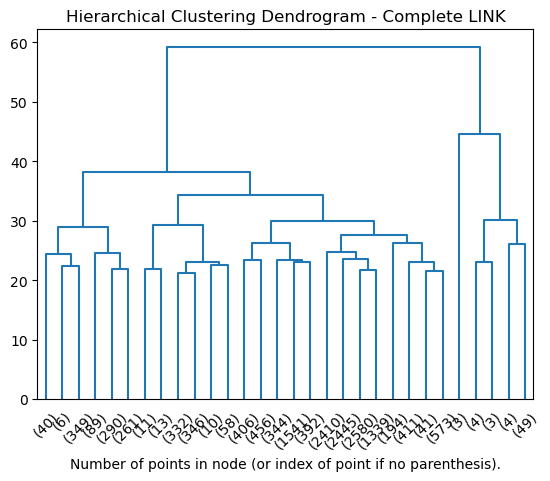

In [22]:
plt.title("Hierarchical Clustering Dendrogram - Complete LINK")
plot_dendrogram(model_2, truncate_mode="lastp", color_threshold=8.5)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [23]:
# get the labels according to a specific threshold value cut
Z_2 = get_linkage_matrix(model_2)
labels_2 = fcluster(Z_2, t=8.5, criterion='distance')

print('Silhouette', silhouette_score(df_z_norm_2, labels_2))

Silhouette 0.04812987597378636


In [24]:
df['hierarchical_labels']=labels_2
labels_2

array([502, 237, 585, ..., 425, 483, 492], dtype=int32)

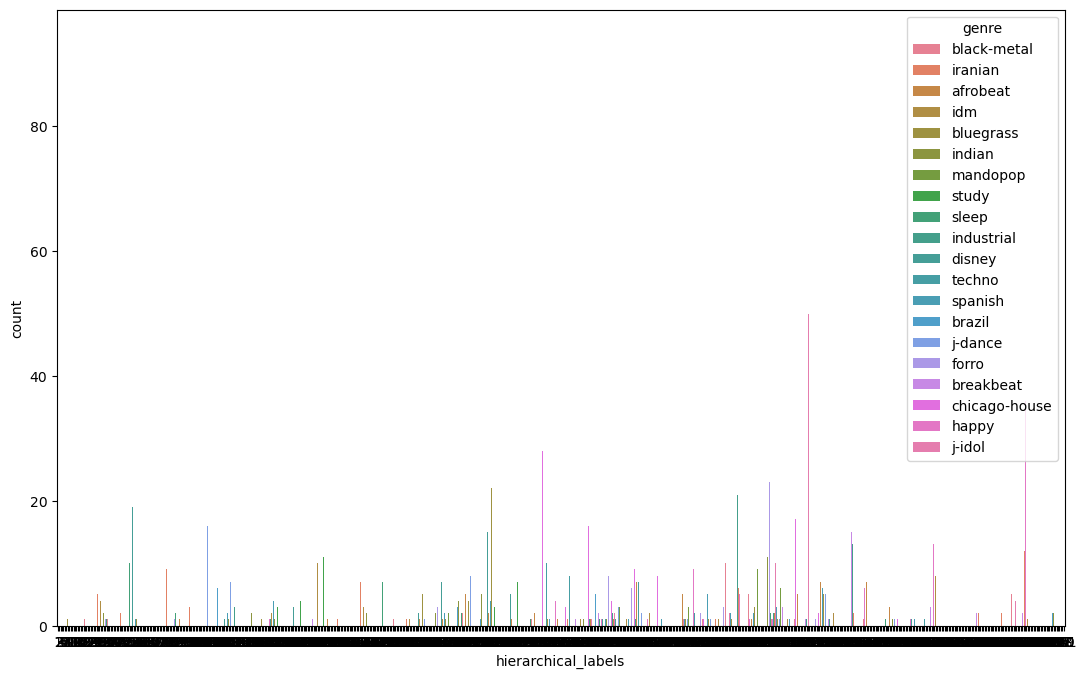

CPU times: total: 3.16 s
Wall time: 3.92 s


In [25]:
%%time

fig = plt.figure(figsize=(13, 8))

sns.countplot(data=df, x='hierarchical_labels', hue='genre', )
plt.show()

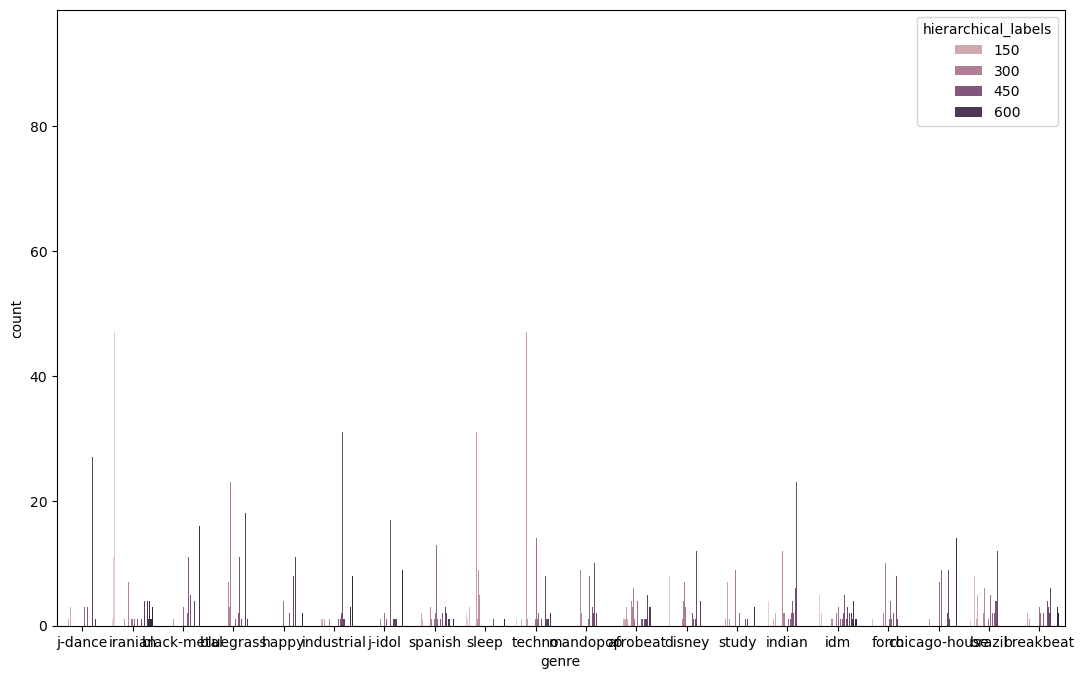

CPU times: total: 4.41 s
Wall time: 5.14 s


In [26]:
%%time

fig = plt.figure(figsize=(13, 8))


sns.countplot(data=df, x='genre', hue='hierarchical_labels', )
plt.show()

In [27]:
df[df['hierarchical_labels']==17].describe()

duration_ms  popularity  danceability    energy        key  \
count       9.000000    9.000000      9.000000  9.000000   9.000000   
mean   177055.888889    3.555556      0.331889  0.642222   5.777778   
std     63506.798241    5.317685      0.100846  0.090759   4.055175   
min     67709.000000    0.000000      0.162000  0.531000   0.000000   
25%    148000.000000    0.000000      0.295000  0.578000   4.000000   
50%    169500.000000    0.000000      0.343000  0.643000   4.000000   
75%    228000.000000    7.000000      0.387000  0.714000   9.000000   
max    270153.000000   13.000000      0.485000  0.797000  11.000000   

        loudness  mode  speechiness  acousticness  instrumentalness  liveness  \
count   9.000000   9.0      9.00000      9.000000          9.000000  9.000000   
mean   -9.389111   0.0      0.06110      0.706889          0.829000  0.220589   
std     3.266059   0.0      0.02804      0.196169          0.117104  0.229177   
min   -15.250000   0.0      0.02830      0.360000          0.640000  0.082300   
25%   -10.623000   0.0      0.04410      0.568000          0.714000  0.105000   
50%    -8.501000   0.0      0.05670      0.725000          0.869000  0.124000   
75%    -7.140000   0.0      0.08500      0.799000          0.925000  0.163000   
max    -5.293000   0.0      0.11000      0.971000          0.948000  0.796000   

        valence       tempo  features_duration_ms  time_signature     n_beats  \
count  9.000000    9.000000              9.000000        9.000000    9.000000   
mean   0.072692  129.669778         177004.000000        3.888889  366.666667   
std    0.041978   11.953406          63563.446131        0.600925  137.422706   
min    0.009730  114.993000          67710.000000        3.000000  128.000000   
25%    0.054400  121.299000         148000.000000        4.000000  268.000000   
50%    0.062300  126.964000         169500.000000        4.000000  357.000000   
75%    0.083600  138.024000         228000.000000        4.000000  482.000000   
max    0.137000  149.984000         270154.000000        5.000000  516.000000   

           n_bars  popularity_confidence  processing  hierarchical_labels  
count    9.000000               2.000000    9.000000                  9.0  
mean    96.777778               0.711500    1.406347                 17.0  
std     34.006535               0.006364    0.886098                  0.0  
min     31.000000               0.707000    0.748116                 17.0  
25%     78.000000               0.709250    0.916010                 17.0  
50%    118.000000               0.711500    0.916010                 17.0  
75%    120.000000               0.713750    1.343558                 17.0  
max    129.000000               0.716000    3.349057                 17.0

In [28]:
df.describe()

duration_ms    popularity  danceability        energy           key  \
count  1.500000e+04  15000.000000  15000.000000  15000.000000  15000.000000   
mean   2.468075e+05     27.423667      0.551063      0.656231      5.287867   
std    1.279941e+05     18.587534      0.194239      0.264371      3.585023   
min    8.586000e+03      0.000000      0.000000      0.000000      0.000000   
25%    1.800000e+05     14.000000      0.441000      0.480000      2.000000   
50%    2.278260e+05     24.000000      0.580000      0.709000      5.000000   
75%    2.889030e+05     42.000000      0.695000      0.884000      8.000000   
max    4.120258e+06     94.000000      0.980000      1.000000     11.000000   

           loudness          mode   speechiness  acousticness  \
count  15000.000000  15000.000000  15000.000000  15000.000000   
mean      -8.894999      0.669550      0.083779      0.303896   
std        6.005799      0.463812      0.086709      0.329536   
min      -49.531000      0.000000      0.000000      0.000000   
25%      -10.636250      0.000000      0.037300      0.009745   
50%       -7.303000      1.000000      0.051000      0.155000   
75%       -5.101000      1.000000      0.088600      0.573000   
max        3.156000      1.000000      0.939000      0.996000   

       instrumentalness      liveness       valence         tempo  \
count      15000.000000  15000.000000  15000.000000  15000.000000   
mean           0.286734      0.216790      0.436853    123.116544   
std            0.382930      0.195295      0.277220     31.930958   
min            0.000000      0.000000      0.000000      0.000000   
25%            0.000000      0.097900      0.196000     99.939000   
50%            0.003130      0.131000      0.416000    124.188000   
75%            0.744000      0.280000      0.664000    141.986500   
max            1.000000      0.994000      0.995000    220.525000   

       features_duration_ms  time_signature       n_beats       n_bars  \
count          1.500000e+04    15000.000000  15000.000000  15000.00000   
mean           2.467947e+05        3.893200    501.862333    128.39340   
std            1.279850e+05        0.527837    280.689804     75.11391   
min            8.587000e+03        0.000000      0.000000      0.00000   
25%            1.800000e+05        4.000000    327.000000     83.00000   
50%            2.278185e+05        4.000000    461.000000    117.00000   
75%            2.889030e+05        4.000000    625.000000    159.00000   
max            4.120258e+06        5.000000   7348.000000   2170.00000   

       popularity_confidence    processing  hierarchical_labels  
count            2217.000000  15000.000000         15000.000000  
mean                0.490479      2.199647           393.308800  
std                 0.291330      1.212616           164.509171  
min                 0.000000      0.748116             1.000000  
25%                 0.230000      1.170953           284.000000  
50%                 0.480000      1.738916           426.000000  
75%                 0.739000      3.349057           513.000000  
max                 1.000000      4.067086           701.000000

#### With 'explicit'

In [30]:
explicit_map={'False':0, 'True':1}

df_exp_clust = df.drop(['hierarchical_labels', 'name', 'artists', 'album_name', 'genre', 'popularity_confidence', 'processing', 'key', 'time_signature', 'features_duration_ms', 'n_beats', 'n_bars'], axis=1)
df_exp_clust.dtypes

duration_ms           int64
explicit               bool
popularity            int64
danceability        float64
energy              float64
loudness            float64
mode                float64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
dtype: object

In [31]:
#Normalization

scaler = StandardScaler()
scaler.fit(df_exp_clust)
df_exp_clust_norm = scaler.transform(df_exp_clust)

In [32]:
# setting distance_threshold=0 ensures we compute the full tree.
model_2 = AgglomerativeClustering(distance_threshold=8.5,
                                n_clusters=None, metric='euclidean', linkage='complete')
model_2 = model_2.fit(df_exp_clust_norm)

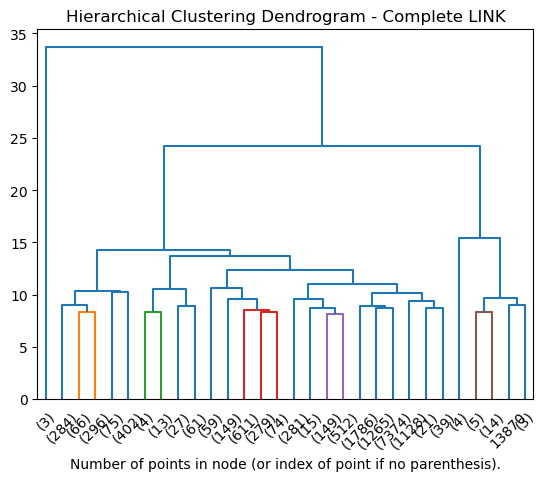

In [33]:
plt.title("Hierarchical Clustering Dendrogram - Complete LINK")
plot_dendrogram(model_2, truncate_mode="lastp", color_threshold=8.5)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [34]:
# get the labels according to a specific threshold value cut
Z_2 = get_linkage_matrix(model_2)
labels_2 = fcluster(Z_2, t=8.5, criterion='distance')

print('Silhouette', silhouette_score(df_z_norm_2, labels_2))

Silhouette 0.0069113330562817965


In [35]:
import random

In [36]:
# setting distance_threshold=0 ensures we compute the full tree.
model_3 = AgglomerativeClustering(distance_threshold=3,
                                n_clusters=None, metric='euclidean', linkage='single')
model_3 = model_3.fit(df_z_norm_2)

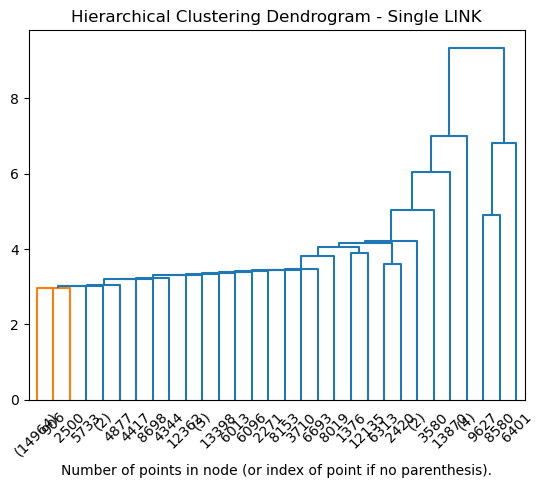

In [37]:
plt.title("Hierarchical Clustering Dendrogram - Single LINK")
plot_dendrogram(model_3, truncate_mode="lastp", color_threshold=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [38]:
# get the labels according to a specific threshold value cut
Z_3 = get_linkage_matrix(model_3)
labels_3 = fcluster(Z_3, t=3, criterion='distance')

print('Silhouette', silhouette_score(df_z_norm_2, labels_3))

Silhouette 0.24977672808100287


In [39]:
# setting distance_threshold=0 ensures we compute the full tree.
model_4 = AgglomerativeClustering(distance_threshold=6,
                                n_clusters=None, metric='euclidean', linkage='average')
model_4 = model_4.fit(df_z_norm_2)

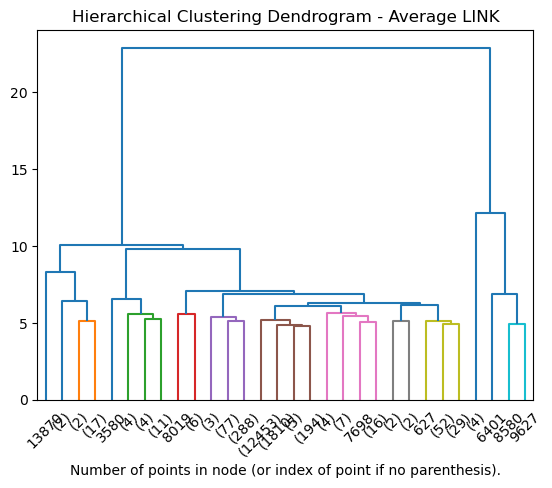

In [40]:
plt.title("Hierarchical Clustering Dendrogram - Average LINK")
plot_dendrogram(model_4, truncate_mode="lastp", color_threshold=6)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [41]:
# get the labels according to a specific threshold value cut
Z_4 = get_linkage_matrix(model_4)
labels_4 = fcluster(Z_4, t=6, criterion='distance')

print('Silhouette', silhouette_score(df_z_norm_2, labels_4))

Silhouette 0.2607767729715059


# K-Means

In [43]:
%%time
sse_list = []
sil_list = []

for k in range(2, 60):
    kmeans = KMeans(init='k-means++', n_clusters=k, n_init=10, max_iter=100)
    kmeans.fit(df_z_norm_2)
    sse_list.append(kmeans.inertia_)
    sil_list.append(silhouette_score(df_z_norm_2, kmeans.labels_))

CPU times: total: 6min 11s
Wall time: 2min 30s


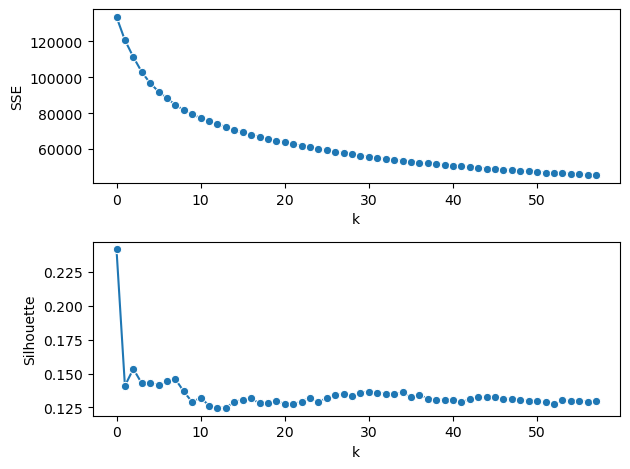

In [44]:
fig, axs = plt.subplots(2) 

sns.lineplot(x=range(len(sse_list)), y=sse_list, marker='o', ax=axs[0])
axs[0].set(xlabel='k', ylabel='SSE')

sns.lineplot(x=range(len(sil_list)), y=sil_list, marker='o', ax=axs[1])
axs[1].set(xlabel='k', ylabel='Silhouette')

plt.tight_layout() # Adjust the padding between and around subplots

In [45]:
kmeans = KMeans(n_clusters=10, n_init=10, max_iter=100, random_state=94)
kmeans.fit(df_z_norm_2)

KMeans(max_iter=100, n_clusters=10, n_init=10, random_state=94)

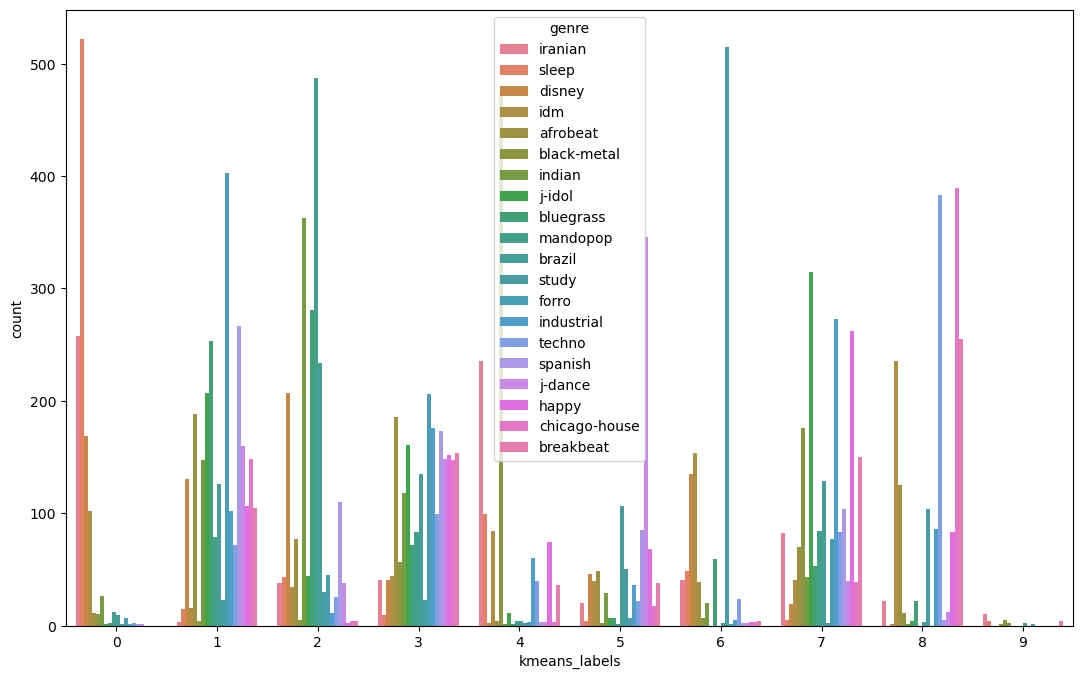

In [46]:
df['kmeans_labels'] = kmeans.labels_

fig = plt.figure(figsize=(13, 8))

sns.countplot(data=df, x='kmeans_labels', hue='genre', )
plt.show()

In [47]:
df[df['kmeans_labels']==9]

name  duration_ms  \
375                    inherited heteronomous perception      1331839   
1376                                     Box Fan on High      1800000   
1948                                               Rajaz      1085962   
2057                               Floden, som kan skabe      1455781   
2420                             Skandha Sashti Kavacham      1223800   
3288     Welcome To The Jungle - Continuous DJ Mix Pt. 1      2733257   
4293                                          Waran 2000      1038586   
6014                                    Est-West, Op. 45      1149100   
6203                                           Fra dyden      1478618   
6269                         Trance/Floden, som kan lede      1163250   
6313                            Tu És o Centro (Ao Vivo)      1357451   
6401                                  Ocean Waves Sounds      4120258   
7341   Welcome To The Jungle Vol. 2 - Continuous DJ M...      2287542   
8019                      Sri Venkateshwara Suprabhatham      1240944   
8580                    Electric Fan (Sound Masking Fan)      3600014   
8698                        Cantos Gregorianos Sanadores      1457998   
8752   Welcome To The Jungle Vol. 2 - Continuous DJ M...      2523428   
8897                      Seu Amor Me Persegue (Ao Vivo)      1035895   
9383        Bass Shakers 2015 - Continuous DJ Mix, Pt. 1      2796984   
9627                  Ruido Rosa Puro - Una Hora Versión      3601693   
9693   TEN #9+1:For Clarinet,Bass Clarinet,Saxophone ...      1512600   
12135                            Nature Sounds Rain Long      1943380   
12163                                          Mod døden      1431042   
12362                                           Otashgah      1149106   
12379        For The World That Sounds Like It's Meaning      1234657   
12843                                              Lalai      1482242   
12868                                  Klippens Lyse Hal      1395338   
13870                                Beyond Tribes Pt. 1      1937632   
14041               Frozen Moment(Moment Gele) 1999-2000      1121226   

       explicit  popularity                                      artists  \
375       False           0                                           Pé   
1376      False          36            Tmsoft’s White Noise Sleep Sounds   
1948      False           0                         Idin Samimi Mofakham   
2057      False          13                                          ORM   
2420      False          52                        Soolamangalam Sisters   
3288      False          19                             Deekline;Ed Solo   
4293      False           0                        Kiawasch Sahebnassagh   
6014      False           0                           Alireza Mashayekhi   
6203      False          16                                          ORM   
6269      False          10                                          ORM   
6313      False          55                                  Frei Gilson   
6401      False          43                                 Ocean Sounds   
7341      False          10                             Ed Solo;Deekline   
8019      False          50                           M. S. Subbulakshmi   
8580      False          36                              Electric Dreams   
8698      False          30                                      Mc_team   
8752      False          12                             Ed Solo;Deekline   
8897      False           2                  Casa Worship;Julliany Souza   
9383      False           9                                    Lady Waks   
9627      False          29                              El Ruido Blanco   
9693      False           0                        Kiawasch Sahebnassagh   
12135     False          36                                Nature Sounds   
12163     False          11                                          ORM   
12362     False           1          

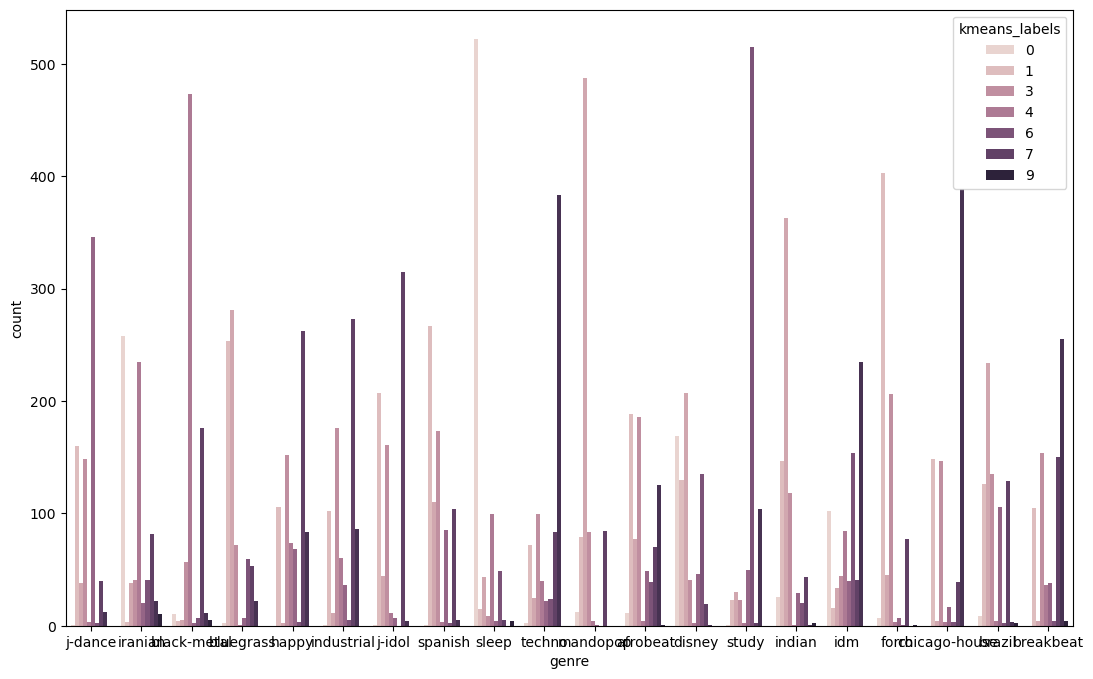

In [48]:
fig = plt.figure(figsize=(13, 8))

sns.countplot(data=df, x='genre', hue='kmeans_labels', )
plt.show()

In [49]:
print('Silhouette', silhouette_score(df_z_norm_2, kmeans.labels_))

Silhouette 0.13655879237206972


In [50]:
kmeans = KMeans(n_clusters=10, n_init=10, max_iter=100, random_state=94)
kmeans.fit(df_z_norm_2)

KMeans(max_iter=100, n_clusters=10, n_init=10, random_state=94)

In [51]:
my_sse = kmeans.inertia_
my_sse

81748.81568685782

In [52]:
N = 500
sse_stats = []

for _ in range(N):
    Xi = np.zeros(shape=df_z_norm_2.shape)
    
    for cidx in range(Xi.shape[1]):
        col = df_z_norm_2[:, cidx]
        min, max, nor = np.min(col), np.max(col), len(col)
        Xi[:, cidx] = np.random.uniform(min, max, (1, nor))
    
    kmeans = KMeans(n_clusters=10, n_init=10, max_iter=100, random_state=94)
    kmeans.fit(Xi)
    sse_stats.append(kmeans.inertia_)

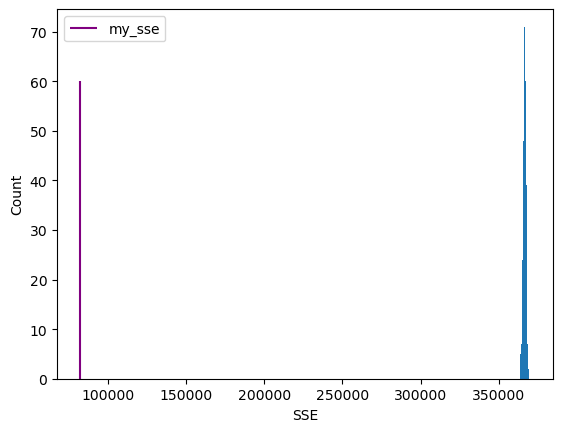

In [53]:
plt.hist(sse_stats, bins='auto')
plt.vlines(x = my_sse, ymin = 0, ymax = 60, colors = 'purple', label = 'my_sse')
plt.xlabel('SSE')
plt.ylabel('Count')
plt.legend()
plt.show()

# Comparison between SSE in our clustering and SSE in random clusterings shows that our clusters are in fact much better, that they make some sense

# DBSCAN

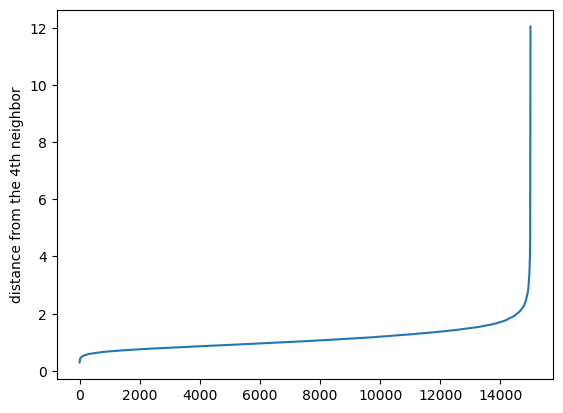

In [55]:
# Distances for DBSCAN

dist = pdist(df_z_norm_2, 'euclidean')
dist = squareform(dist)

k=4
kth_distances = []

for d in dist:  # d is a vector containing distances between the ith record and all the others
    index_kth_distance = np.argsort(d)[k]  # take the index of the kth nearest neighbor
    kth_distances.append(d[index_kth_distance])  # store the distance in a list

plt.plot(range(0, len(kth_distances)), sorted(kth_distances))
plt.ylabel('distance from the {}th neighbor'.format(k))
         
plt.show()

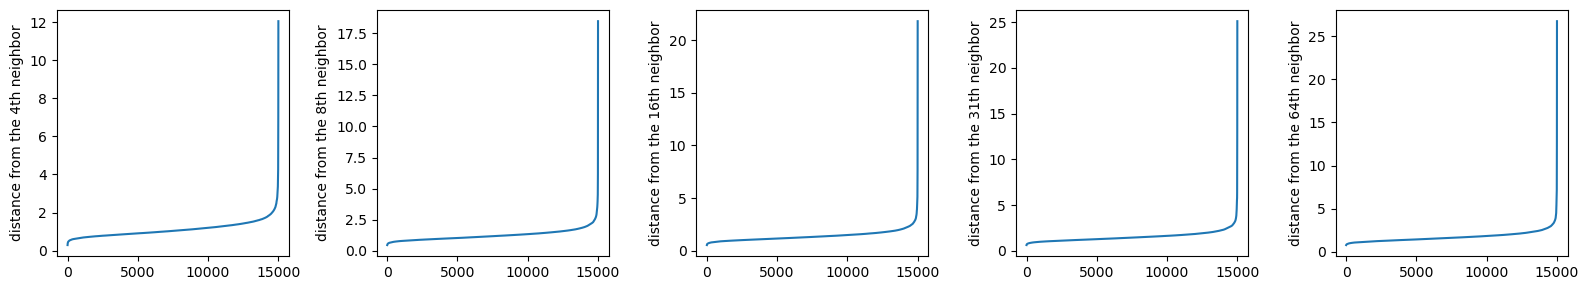

In [56]:
ks = [4, 8, 16, 31, 64]

fig = plt.figure(figsize=(16, 3)) # dimensions of the overall plot
fig_dims = (1, len(ks))

for i in range(len(ks)):
    k = ks[i]
    kth_distances = []

    for d in dist:  # d is a vector containing distances between the ith record and all the others
        index_kth_distance = np.argsort(d)[k]  # take the index of the kth nearest neighbor
        kth_distances.append(d[index_kth_distance])  # store the distance in a list

    plt.subplot2grid(fig_dims, (0, i))
    plt.plot(range(0, len(kth_distances)), sorted(kth_distances))
    plt.ylabel('distance from the {}th neighbor'.format(k))
             
plt.tight_layout()
plt.show()

In [57]:
dbscan = DBSCAN(eps=2.75, min_samples=4, metric = 'cityblock')
dbscan.fit(df_z_norm_2)


#            Euclidean
# With eps=1.5, min_samples=4, 1700 outliers but |0|=13000
# With eps=1.2, min_samples=4, 4666 outliers but |0|=9860
# With eps=1, min_samples=4, 8013 outliers but |0|=4497
# With eps=1, min_samples=10, 10576 outliers but |0|=3020
# With eps=2, min_samples=5, 430 outliers but |0|=14525
# With eps=1.5, min_samples=5, 1900 outliers but |0|=12995
# With eps=1, min_samples=5, 900 outliers but |0|=13923
# With eps=1.25, min_samples=5, 4324 outliers but |0|=10441

#            Manhattan
# With eps=2.75, min_samples=4, 5634 outliers but |0|=8978
# With eps=3, min_samples=5, 4472 outliers but |0|=10305
# With eps=4, min_samples=5, 1120 outliers but |0|=13798
# With eps=3, min_samples=8, 5414 outliers but |0|=9428
# With eps=4, min_samples=8, 1319 outliers but |0|=13618
# With eps=3, min_samples=10, 5883 outliers but |0|=8426
# With eps=4, min_samples=10, 1457 outliers but |0|=13421
# With eps=3, min_samples=12, 6249 outliers but |0|=8102
# With eps=4, min_samples=12, 1552 outliers but |0|=13331
# With eps=3, min_samples=12, 6991 outliers but |0|=7501

DBSCAN(eps=2.75, metric='cityblock', min_samples=4)

In [58]:
df['dbscan_labels'] = dbscan.labels_

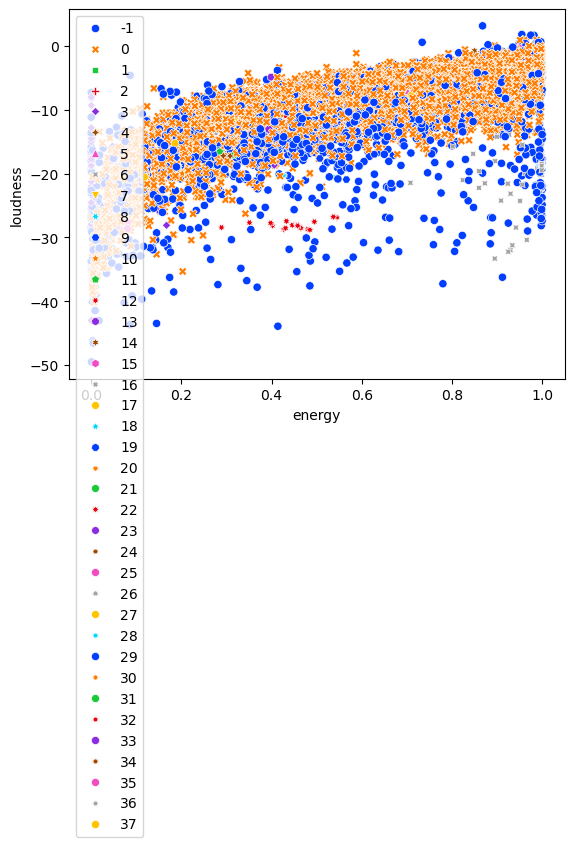

In [59]:
sns.scatterplot(data=df, 
                x="energy", 
                y="loudness", 
                hue=dbscan.labels_, 
                style=dbscan.labels_, 
                palette="bright")
plt.show()

In [60]:
df[df['dbscan_labels']==0].describe()

duration_ms    popularity  danceability        energy           key  \
count   11702.000000  11702.000000  11702.000000  11702.000000  11702.000000   
mean   245710.427021     28.285678      0.567292      0.683791      5.294480   
std     85295.046258     18.396812      0.175660      0.253711      3.570828   
min     24000.000000      0.000000      0.056200      0.000603      0.000000   
25%    189240.000000     16.000000      0.468000      0.522000      2.000000   
50%    232306.500000     25.000000      0.589000      0.743000      5.000000   
75%    286953.500000     43.000000      0.696000      0.896000      8.000000   
max    730552.000000     88.000000      0.980000      0.999000     11.000000   

           loudness          mode   speechiness  acousticness  \
count  11702.000000  11702.000000  11702.000000  11702.000000   
mean      -7.964480      0.699902      0.068952      0.272776   
std        5.234848      0.454393      0.059843      0.319774   
min      -40.227000      0.000000      0.022800      0.000000   
25%       -9.389250      0.000000      0.036200      0.006092   
50%       -6.745500      1.000000      0.047900      0.109000   
75%       -4.809000      1.000000      0.075100      0.504750   
max        1.028000      1.000000      0.503000      0.996000   

       instrumentalness  ...         tempo  features_duration_ms  \
count      11702.000000  ...  11702.000000          11702.000000   
mean           0.232638  ...    124.051745         245694.158178   
std            0.359902  ...     28.812490          85277.467296   
min            0.000000  ...     35.790000          24000.000000   
25%            0.000000  ...    101.198000         189240.000000   
50%            0.000521  ...    124.993500         232307.500000   
75%            0.532750  ...    140.105000         286954.500000   
max            1.000000  ...    208.225000         730552.000000   

       time_signature       n_beats        n_bars  popularity_confidence  \
count     11702.00000  11702.000000  11702.000000            1733.000000   
mean          3.93719    503.455392    128.022731               0.494656   
std           0.36733    214.006365     55.541118               0.290976   
min           0.00000     36.000000     11.000000               0.000000   
25%           4.00000    348.000000     88.000000               0.235000   
50%           4.00000    473.000000    119.000000               0.486000   
75%           4.00000    624.000000    159.000000               0.744000   
max           5.00000   1735.000000    512.000000               1.000000   

         processing  hierarchical_labels  kmeans_labels  dbscan_labels  
count  11702.000000         11702.000000   11702.000000        11702.0  
mean       2.212169           410.727568       3.773970            0.0  
std        1.220044           147.945822       2.659896            0.0  
min        0.748116             8.000000       0.000000            0.0  
25%        1.170953           308.000000       1.000000            0.0  
50%        2.367412           443.000000       3.000000            0.0  
75%        3.349057           509.000000       7.000000            0.0  
max        4.067086           694.000000       8.000000            0.0  

[8 rows x 22 columns]

# HDBSCAN

In [62]:
from sklearn.cluster import HDBSCAN

In [63]:
hdb = HDBSCAN(cluster_selection_epsilon=2, min_samples=4, 
              min_cluster_size=10, max_cluster_size=15,
              store_centers="centroid")
hdb.fit(df_z_norm_2)

HDBSCAN(cluster_selection_epsilon=2, max_cluster_size=15, min_cluster_size=10,
        min_samples=4, store_centers='centroid')

In [64]:
df['hdbscan_labels'] = hdb.labels_

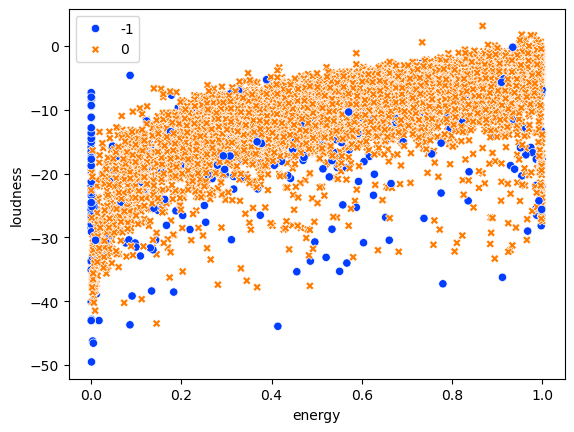

In [65]:
sns.scatterplot(data=df, 
                x="energy",
                y="loudness", 
                hue=hdb.labels_, 
                style=hdb.labels_, 
                palette="bright")

#plt.scatter(scaler.inverse_transform(hdb.centroids_)[:,0], scaler.inverse_transform(hdb.centroids_)[:,2], c='red', marker='*', s=200)
plt.show()

In [66]:
print('Silhouette', silhouette_score(df_z_norm_2, hdb.labels_ != -1))

Silhouette 0.3573639413851549


In [67]:
df[df['hdbscan_labels']==0].describe()

duration_ms    popularity  danceability        energy           key  \
count   14560.000000  14560.000000  14560.000000  14560.000000  14560.000000   
mean   242961.907967     27.525206      0.557237      0.662962      5.289698   
std     95782.873718     18.560965      0.187668      0.259097      3.580998   
min     24000.000000      0.000000      0.000000      0.000020      0.000000   
25%    181350.250000     14.000000      0.450000      0.488000      2.000000   
50%    228053.000000     24.000000      0.583000      0.715000      5.500000   
75%    287476.000000     42.000000      0.696000      0.886000      8.000000   
max    892319.000000     88.000000      0.980000      1.000000     11.000000   

           loudness          mode   speechiness  acousticness  \
count  14560.000000  14560.000000  14560.000000  14560.000000   
mean      -8.651468      0.672321      0.080267      0.298897   
std        5.708355      0.463020      0.076832      0.327057   
min      -43.504000      0.000000      0.000000      0.000000   
25%      -10.365000      0.000000      0.037300      0.009280   
50%       -7.199500      1.000000      0.050600      0.149000   
75%       -5.052750      1.000000      0.086400      0.561000   
max        3.156000      1.000000      0.606000      0.996000   

       instrumentalness  ...  features_duration_ms  time_signature  \
count      14560.000000  ...          14560.000000    14560.000000   
mean           0.280830  ...         242948.796291        3.920330   
std            0.380746  ...          95770.063673        0.424504   
min            0.000000  ...          24000.000000        0.000000   
25%            0.000000  ...         181350.250000        4.000000   
50%            0.002415  ...         228040.000000        4.000000   
75%            0.730000  ...         287477.000000        4.000000   
max            1.000000  ...         892320.000000        5.000000   

            n_beats        n_bars  popularity_confidence    processing  \
count  14560.000000  14560.000000            2163.000000  14560.000000   
mean     497.207692    126.909203               0.491037      2.203166   
std      233.468304     61.116941               0.291864      1.215067   
min        0.000000      0.000000               0.000000      0.748116   
25%      331.000000     84.000000               0.230000      1.170953   
50%      462.000000    117.000000               0.482000      1.738916   
75%      622.000000    159.000000               0.740000      3.349057   
max     2203.000000    679.000000               1.000000      4.067086   

       hierarchical_labels  kmeans_labels  dbscan_labels  hdbscan_labels  
count         14560.000000   14560.000000   14560.000000         14560.0  
mean            397.499588       3.860920       0.048626             0.0  
std             159.675743       2.617699       2.195406             0.0  
min               5.000000       0.000000      -1.000000             0.0  
25%             288.000000       2.000000       0.000000             0.0  
50%             431.000000       3.000000       0.000000             0.0  
75%             513.000000       7.000000       0.000000             0.0  
max             700.000000       8.000000      37.000000             0.0  

[8 rows x 23 columns]

# Classification

In [68]:
test = pd.read_csv('datasets/test.csv')

In [69]:
test_2 = test.drop(['liveness', 'name', 'artists', 'album_name', 'genre', 'explicit', 'popularity_confidence', 'processing', 'key', 'time_signature', 'features_duration_ms', 'n_beats', 'n_bars'], axis=1)

In [70]:
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
)
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall

In [71]:
from sklearn.neighbors import KNeighborsClassifier

In [72]:
y_train = df['genre']

In [73]:
y_test = test['genre']

In [74]:
#Normalization for the test set WITH 'mode'

scaler = StandardScaler()
scaler.fit(test_2)
test_norm = scaler.transform(test_2)

In [75]:
test_2.isnull().sum()

duration_ms            0
popularity             0
danceability           0
energy                 0
loudness               0
mode                1461
speechiness            0
acousticness           0
instrumentalness       0
valence                0
tempo                  0
dtype: int64

In [76]:
test_no = test_2.drop(['mode'], axis=1)

In [77]:
#Normalization for the test set WITHOUT 'mode'

scaler = StandardScaler()
scaler.fit(test_no)
test_norm_no = scaler.transform(test_no)

In [78]:
df_train_nomode = df_train_2.drop(['mode'], axis=1)

#Normalization

scaler = StandardScaler()
scaler.fit(df_train_nomode)
df_z_norm_nomode = scaler.transform(df_train_nomode)

### WITHOUT using 'mode'

In [80]:
#test_no=test_no.drop(['liveness'], axis=1)

scaler = StandardScaler()
scaler.fit(test_no)
test_norm_no = scaler.transform(test_no)


#df_train_nomode=df_train_nomode.drop(['liveness'], axis=1)

scaler = StandardScaler()
scaler.fit(df_train_nomode)
df_z_norm_nomode = scaler.transform(df_train_nomode)

In [81]:
clf = KNeighborsClassifier(n_neighbors=11, metric="manhattan", weights="uniform")
clf.fit(df_z_norm_nomode, y_train)

KNeighborsClassifier(metric='manhattan', n_neighbors=11)

In [82]:
# predict: Predict the class labels for the provided data.
y_test_pred = clf.predict(test_norm_no)
y_test_pred

array(['industrial', 'idm', 'mandopop', ..., 'industrial', 'black-metal',
       'breakbeat'], dtype=object)

In [83]:
y_test

0        industrial
1         breakbeat
2            indian
3            j-idol
4         breakbeat
           ...     
4995         disney
4996        iranian
4997     industrial
4998    black-metal
4999     industrial
Name: genre, Length: 5000, dtype: object

In [84]:
print("Accuracy:", accuracy_score(y_test, y_test_pred))

Accuracy: 0.5426


In [85]:
print("F1:", f1_score(y_test, y_test_pred, average="macro"))

F1: 0.5345377875010462


In [86]:
print(classification_report(y_test, y_test_pred))

               precision    recall  f1-score   support

     afrobeat       0.36      0.32      0.34       250
  black-metal       0.67      0.77      0.71       250
    bluegrass       0.52      0.68      0.58       250
       brazil       0.42      0.46      0.44       250
    breakbeat       0.40      0.36      0.38       250
chicago-house       0.57      0.68      0.62       250
       disney       0.60      0.52      0.56       250
        forro       0.57      0.70      0.63       250
        happy       0.48      0.56      0.52       250
          idm       0.51      0.32      0.39       250
       indian       0.45      0.32      0.38       250
   industrial       0.47      0.39      0.43       250
      iranian       0.65      0.66      0.65       250
      j-dance       0.52      0.59      0.55       250
       j-idol       0.57      0.64      0.60       250
     mandopop       0.40      0.59      0.48       250
        sleep       0.87      0.79      0.83       250
      spa

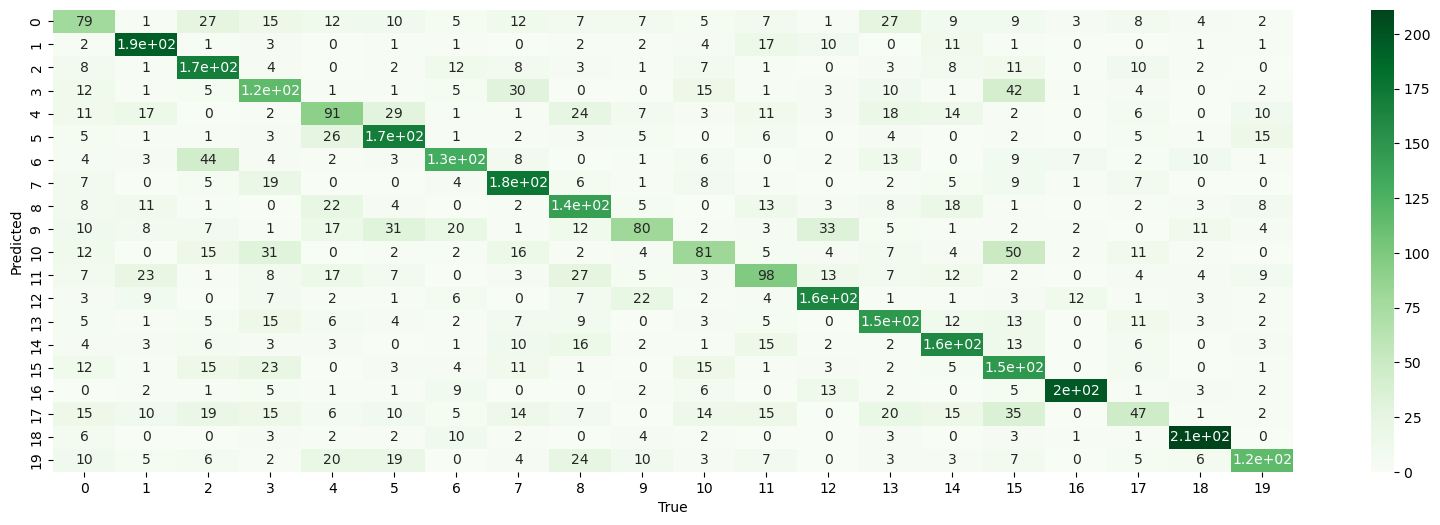

In [87]:
fig = plt.figure(figsize=(20, 6))

cf = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cf, annot=True, cmap="Greens")
plt.xlabel("True")
plt.ylabel("Predicted")
plt.show()

In [88]:
# Return probability estimates for the test data X.
y_test_pred_proba = clf.predict_proba(test_norm_no)
y_test_pred_proba[0:10]

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.09090909, 0.        ,
        0.        , 0.45454545, 0.        , 0.09090909, 0.09090909,
        0.        , 0.        , 0.27272727, 0.        , 0.        ],
       [0.        , 0.18181818, 0.        , 0.        , 0.18181818,
        0.        , 0.        , 0.        , 0.18181818, 0.36363636,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.09090909],
       [0.09090909, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.09090909, 0.09090909, 0.        , 0.        ,
        0.09090909, 0.        , 0.09090909, 0.        , 0.09090909,
        0.36363636, 0.        , 0.09090909, 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.18181818, 0.        ,
        0.        , 0.36363636, 0.        , 0

In [89]:
y_test_pred[0:10]

array(['industrial', 'idm', 'mandopop', 'j-idol', 'chicago-house',
       'afrobeat', 'disney', 'idm', 'mandopop', 'iranian'], dtype=object)

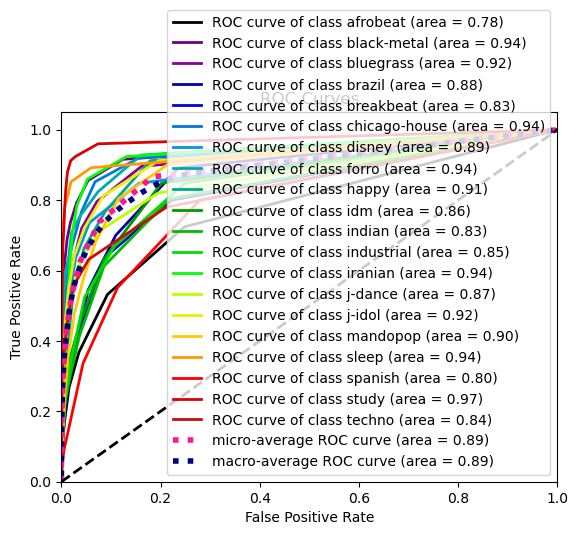

In [90]:
plot_roc(y_test, y_test_pred_proba)
plt.show()

In [91]:
roc_auc_score(y_test, y_test_pred_proba, multi_class="ovr", average="macro")

0.8879941052631578

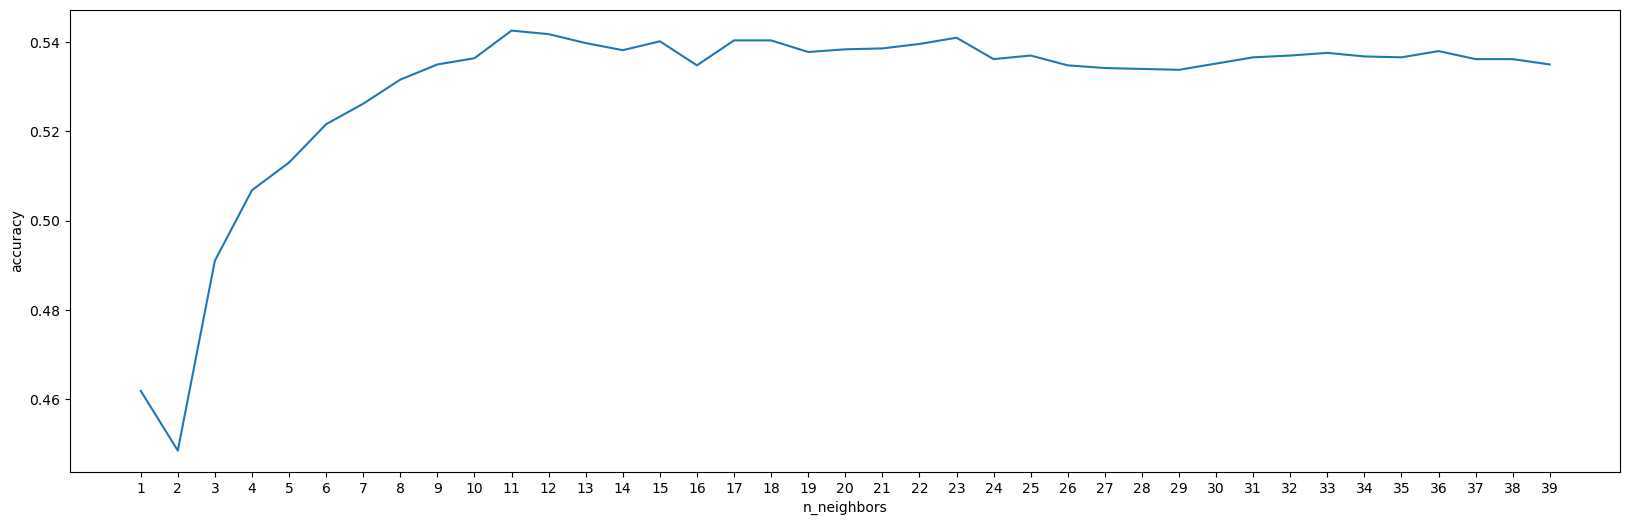

CPU times: total: 23.5 s
Wall time: 27 s


In [92]:
%%time

n_neighbors = range(1,40)
scores = list()

for n in n_neighbors:
    clf = KNeighborsClassifier(n_neighbors=n, metric="manhattan", weights="uniform")
    clf.fit(df_z_norm_nomode, y_train)
    scores.append(clf.score(test_norm_no, y_test))

fig = plt.figure(figsize=(20, 6))

plt.plot(scores)
plt.xticks(range(len(n_neighbors)), n_neighbors)
plt.xlabel("n_neighbors")
plt.ylabel("accuracy")
plt.show()

### WITH 'mode'

In [94]:
#Filling missing values for 'mode' in test

test_mode_fill_median = test.groupby(['artists'])['mode'].transform(fun_fill_median)
test['mode'] = test_mode_fill_median

test_mode_fill_median1 = test.groupby(['valence'])['mode'].transform(fun_fill_median)
test['mode'] = test_mode_fill_median1

test_mode_fill_median2 = test.groupby(['genre'])['mode'].transform(fun_fill_median)
test['mode'] = test_mode_fill_median2

test_time_sign_fill_median = test.groupby(['genre'])['time_signature'].transform(fun_fill_median)
test['time_signature'] = test_time_sign_fill_median


test['mode'].isnull().sum()

0

In [95]:
test['time_signature'].isnull().sum()

0

In [96]:
test_2 = test.drop(['liveness','name', 'artists', 'album_name', 'genre', 'explicit', 'popularity_confidence', 'processing', 'key', 'time_signature', 'features_duration_ms', 'n_beats', 'n_bars'], axis=1)

#Normalization for the test set WITH 'mode'

scaler = StandardScaler()
scaler.fit(test_2)
test_norm = scaler.transform(test_2)

In [97]:
clf = KNeighborsClassifier(n_neighbors=33, metric="manhattan", weights="uniform")
clf.fit(df_z_norm_2, y_train)

KNeighborsClassifier(metric='manhattan', n_neighbors=33)

In [98]:
# predict: Predict the class labels for the provided data.
y_test_pred = clf.predict(test_norm)
y_test_pred

array(['industrial', 'techno', 'j-idol', ..., 'j-idol', 'black-metal',
       'happy'], dtype=object)

In [99]:
print("Accuracy:", accuracy_score(y_test, y_test_pred))

Accuracy: 0.52


In [100]:
print("F1:", f1_score(y_test, y_test_pred, average="macro"))

F1: 0.5078668253054853


In [101]:
print(classification_report(y_test, y_test_pred))

               precision    recall  f1-score   support

     afrobeat       0.45      0.31      0.37       250
  black-metal       0.66      0.73      0.69       250
    bluegrass       0.48      0.68      0.57       250
       brazil       0.39      0.37      0.38       250
    breakbeat       0.37      0.29      0.33       250
chicago-house       0.53      0.67      0.59       250
       disney       0.61      0.45      0.52       250
        forro       0.57      0.71      0.63       250
        happy       0.47      0.55      0.51       250
          idm       0.54      0.25      0.34       250
       indian       0.41      0.26      0.31       250
   industrial       0.36      0.33      0.34       250
      iranian       0.62      0.64      0.63       250
      j-dance       0.48      0.60      0.53       250
       j-idol       0.49      0.68      0.57       250
     mandopop       0.37      0.63      0.46       250
        sleep       0.87      0.75      0.81       250
      spa

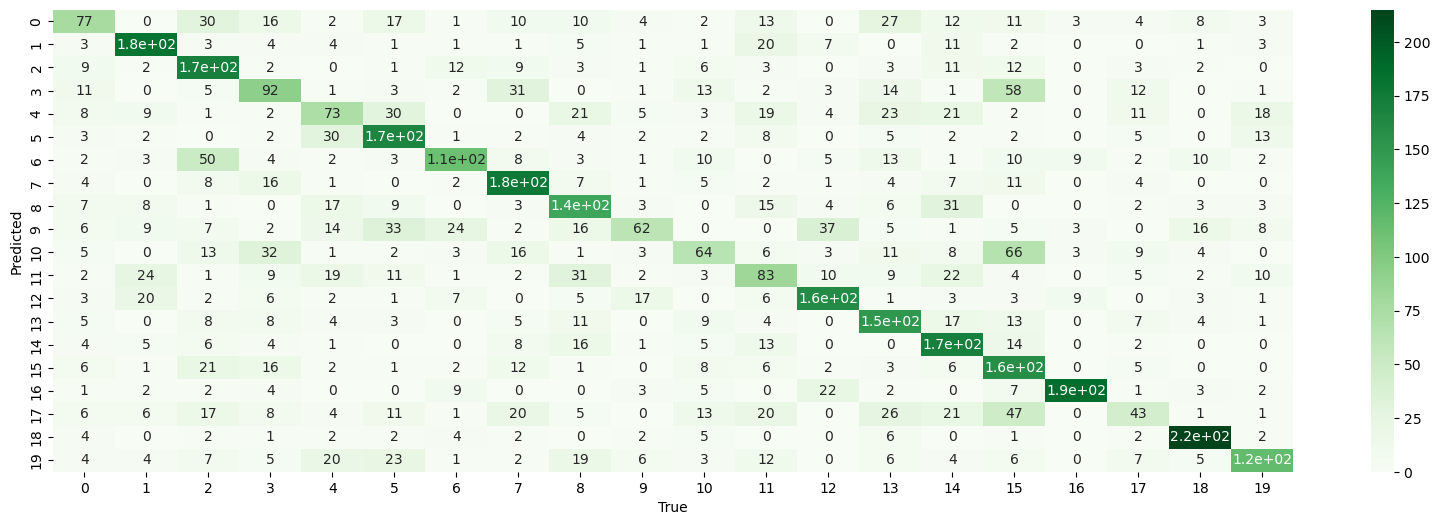

In [102]:
fig = plt.figure(figsize=(20, 6))

cf = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cf, annot=True, cmap="Greens")
plt.xlabel("True")
plt.ylabel("Predicted")
plt.show()

In [103]:
# Return probability estimates for the test data X.
y_test_pred_proba = clf.predict_proba(test_norm)

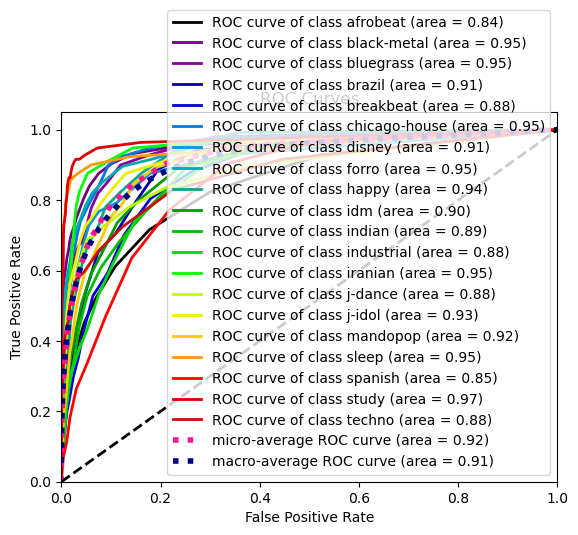

In [104]:
plot_roc(y_test, y_test_pred_proba)
plt.show()

In [105]:
roc_auc_score(y_test, y_test_pred_proba, multi_class="ovr", average="macro")

0.9145226947368423

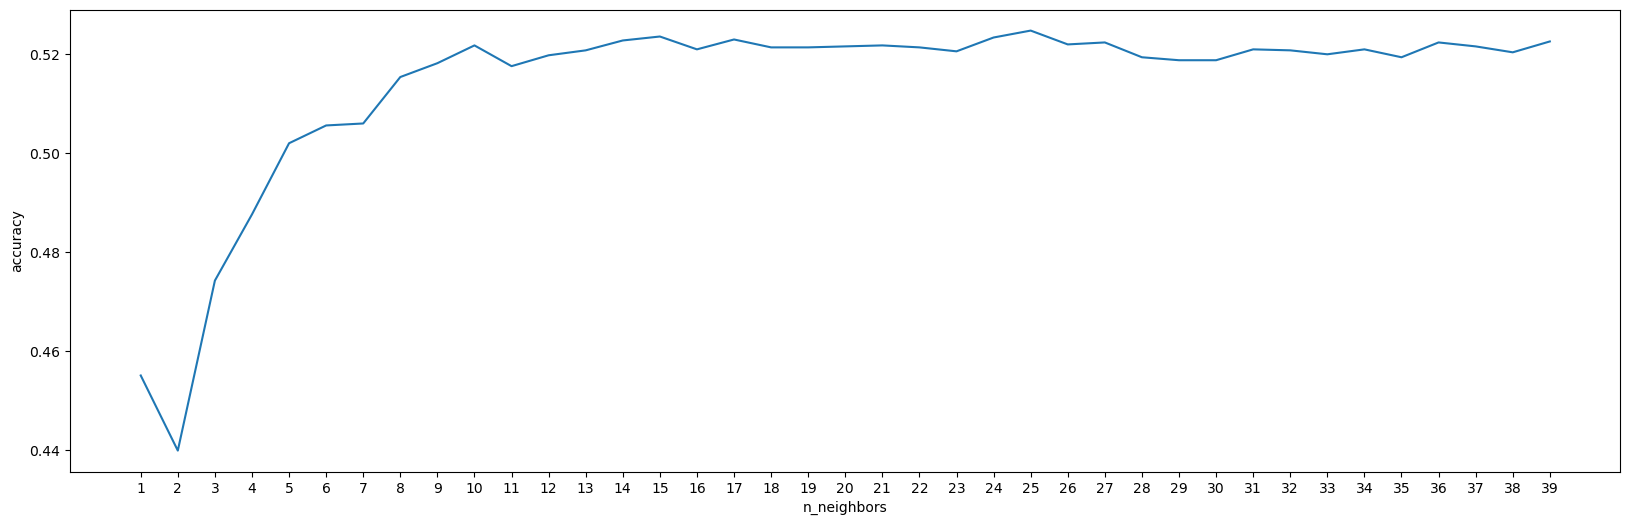

CPU times: total: 29.2 s
Wall time: 37.7 s


In [106]:
%%time

n_neighbors = range(1,40)
scores = list()

for n in n_neighbors:
    clf = KNeighborsClassifier(n_neighbors=n, metric="manhattan", weights="uniform")
    clf.fit(df_z_norm_2, y_train)
    scores.append(clf.score(test_norm, y_test))

fig = plt.figure(figsize=(20, 6))

plt.plot(scores)
plt.xticks(range(len(n_neighbors)), n_neighbors)
plt.xlabel("n_neighbors")
plt.ylabel("accuracy")
plt.show()

### With 'explicit' (it is better 'explicit' without 'mode' than having both)

In [108]:
explicit_map={'False':0, 'True':1}

In [109]:
df_explicit = df.replace({'explicit':explicit_map})
df_explicit_2 = df_explicit.drop(['dbscan_labels', 'hdbscan_labels', 'kmeans_labels', 'mode', 'hierarchical_labels', 'name', 'artists', 'album_name', 'genre', 'popularity_confidence', 'processing', 'key', 'time_signature', 'features_duration_ms', 'n_beats', 'n_bars'], axis=1)
df_explicit_2.dtypes

duration_ms           int64
explicit               bool
popularity            int64
danceability        float64
energy              float64
loudness            float64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
dtype: object

In [110]:
#Normalization

scaler = StandardScaler()
scaler.fit(df_explicit_2)
df_exp_norm = scaler.transform(df_explicit_2)

In [111]:
df_exp_norm

array([[-0.03943658, -0.26236012,  0.99943074, ...,  0.32879478,
         0.71478937,  0.59832508],
       [ 1.54068948, -0.26236012, -1.47542871, ...,  0.7333244 ,
        -1.454678  , -1.48827752],
       [ 0.67738623, -0.26236012, -1.31402484, ...,  0.23150285,
         0.18811455, -0.20321219],
       ...,
       [ 1.19762304, -0.26236012,  0.83802687, ..., -0.74500094,
        -1.32048414,  0.09030586],
       [-0.3871987 , -0.26236012,  0.51521911, ...,  0.94839079,
        -0.60189767,  1.15651672],
       [-0.37814329, -0.26236012,  0.46141782, ..., -0.65948645,
         1.25228627, -1.09970749]])

In [112]:
test_exp = test.drop(['mode', 'name', 'artists', 'album_name', 'genre', 'popularity_confidence', 'processing', 'key', 'time_signature', 'features_duration_ms', 'n_beats', 'n_bars'], axis=1)

#Normalization for the test set WITH 'mode'

scaler = StandardScaler()
scaler.fit(test_exp)
test_exp_norm = scaler.transform(test_exp)

In [113]:
test_exp=test_exp.drop(['liveness'], axis=1)

scaler = StandardScaler()
scaler.fit(test_exp)
test_exp_norm = scaler.transform(test_exp)


df_explicit_2=df_explicit_2.drop(['liveness'], axis=1)

scaler = StandardScaler()
scaler.fit(df_explicit_2)
df_exp_norm = scaler.transform(df_explicit_2)

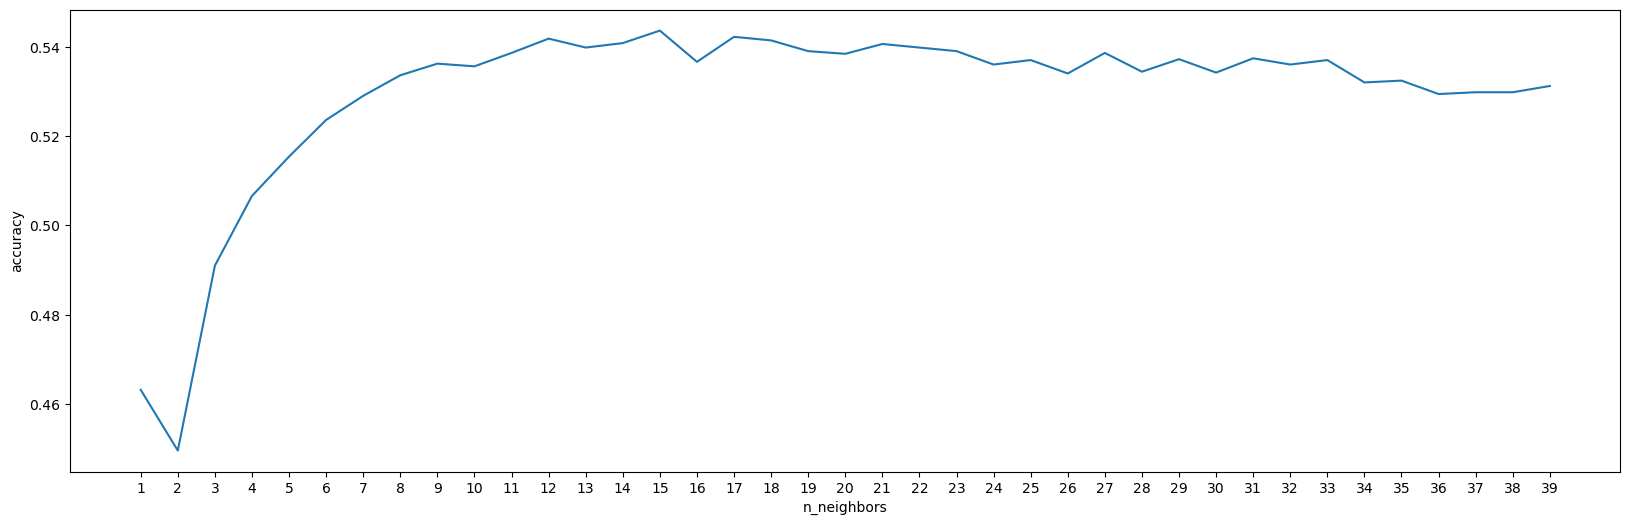

CPU times: total: 29.9 s
Wall time: 34.5 s


In [114]:
%%time

n_neighbors = range(1,40)
scores = list()

for n in n_neighbors:
    clf = KNeighborsClassifier(n_neighbors=n, metric="manhattan", weights="uniform")
    clf.fit(df_exp_norm, y_train)
    scores.append(clf.score(test_exp_norm, y_test))

fig = plt.figure(figsize=(20, 6))

plt.plot(scores)
plt.xticks(range(len(n_neighbors)), n_neighbors)
plt.xlabel("n_neighbors")
plt.ylabel("accuracy")
plt.show()

In [115]:
clf = KNeighborsClassifier(n_neighbors=15, metric="manhattan", weights="uniform")
clf.fit(df_exp_norm, y_train)

KNeighborsClassifier(metric='manhattan', n_neighbors=15)

In [116]:
# predict: Predict the class labels for the provided data.
y_test_pred = clf.predict(test_exp_norm)
y_test_pred

array(['industrial', 'idm', 'mandopop', ..., 'industrial', 'black-metal',
       'happy'], dtype=object)

In [117]:
print("Accuracy:", accuracy_score(y_test, y_test_pred))

Accuracy: 0.5436


In [118]:
print(classification_report(y_test, y_test_pred))

               precision    recall  f1-score   support

     afrobeat       0.40      0.32      0.35       250
  black-metal       0.68      0.76      0.71       250
    bluegrass       0.52      0.68      0.58       250
       brazil       0.37      0.43      0.40       250
    breakbeat       0.42      0.36      0.39       250
chicago-house       0.56      0.67      0.61       250
       disney       0.63      0.53      0.58       250
        forro       0.58      0.71      0.64       250
        happy       0.49      0.52      0.50       250
          idm       0.53      0.31      0.39       250
       indian       0.47      0.32      0.38       250
   industrial       0.46      0.38      0.41       250
      iranian       0.62      0.68      0.65       250
      j-dance       0.52      0.64      0.58       250
       j-idol       0.54      0.69      0.60       250
     mandopop       0.40      0.60      0.48       250
        sleep       0.89      0.76      0.82       250
      spa

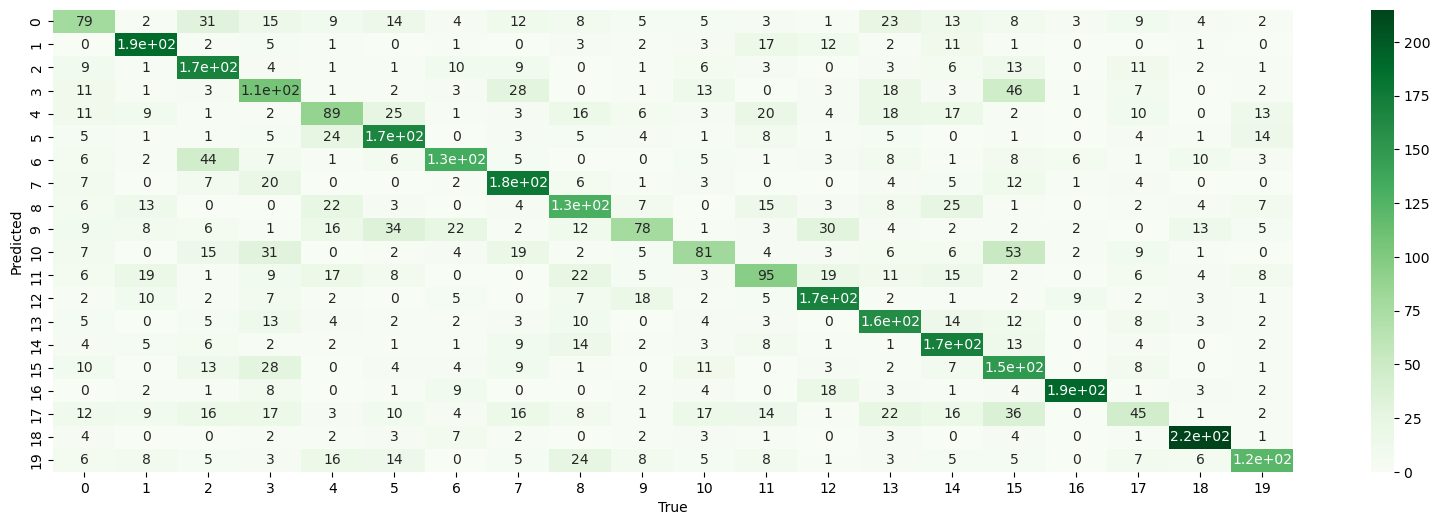

In [119]:
fig = plt.figure(figsize=(20, 6))

cf = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cf, annot=True, cmap="Greens")
plt.xlabel("True")
plt.ylabel("Predicted")
plt.show()

In [120]:
# Return probability estimates for the test data X.
y_test_pred_proba = clf.predict_proba(test_exp_norm)

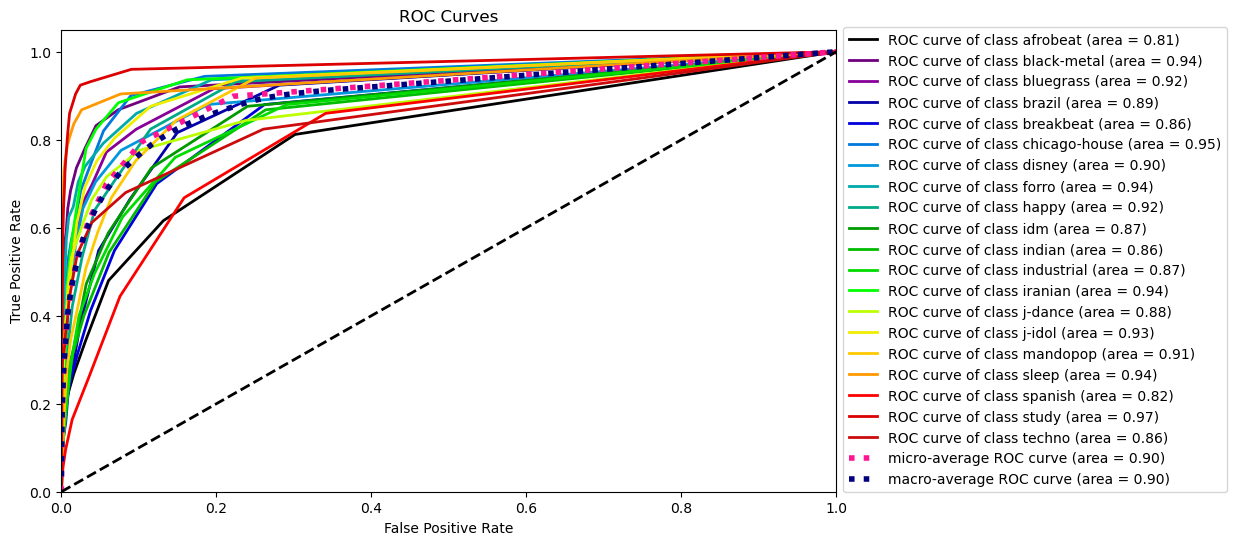

In [121]:
plot_roc(y_test, y_test_pred_proba, figsize=(10,6))
plt.legend(bbox_to_anchor=(1, 1.02), loc='upper left')
plt.show()

In [122]:
roc_auc_score(y_test, y_test_pred_proba, multi_class="ovr", average="macro")

0.9001297263157895

With 'explicit' the accuracy of the prediction model is the highest I've found (0.5136), but the ROC curves are much worses than the other tries, since it is 0.83, while the others are around 0.88-0.91.

#### With 'key'

In [125]:
# one-hot encoding of categorical data
categorical_cols = ["key"]
df = pd.get_dummies(df, columns=categorical_cols, dtype=int)

In [126]:
df_key = df.drop(['kmeans_labels', 'hierarchical_labels', 'dbscan_labels', 'hdbscan_labels', 'mode', 'name', 'artists', 'album_name', 'genre', 'popularity_confidence', 'processing', 'time_signature', 'features_duration_ms', 'n_beats', 'n_bars'], axis=1)
df_key = df_key.drop(['liveness'], axis=1)

In [127]:
#Normalization

scaler = StandardScaler()
scaler.fit(df_key)
df_key_norm = scaler.transform(df_key)

In [128]:
# one-hot encoding of categorical data
categorical_cols = ["key"]
test_keys = pd.get_dummies(test, columns=categorical_cols, dtype=int)

test_key = test_keys.drop(['mode', 'name', 'artists', 'album_name', 'genre', 'popularity_confidence', 'processing', 'time_signature', 'features_duration_ms', 'n_beats', 'n_bars'], axis=1)
test_key = test_key.drop(['liveness'], axis=1)

#Normalization for the test set WITH 'mode'

scaler = StandardScaler()
scaler.fit(test_key)
test_key_norm = scaler.transform(test_key)

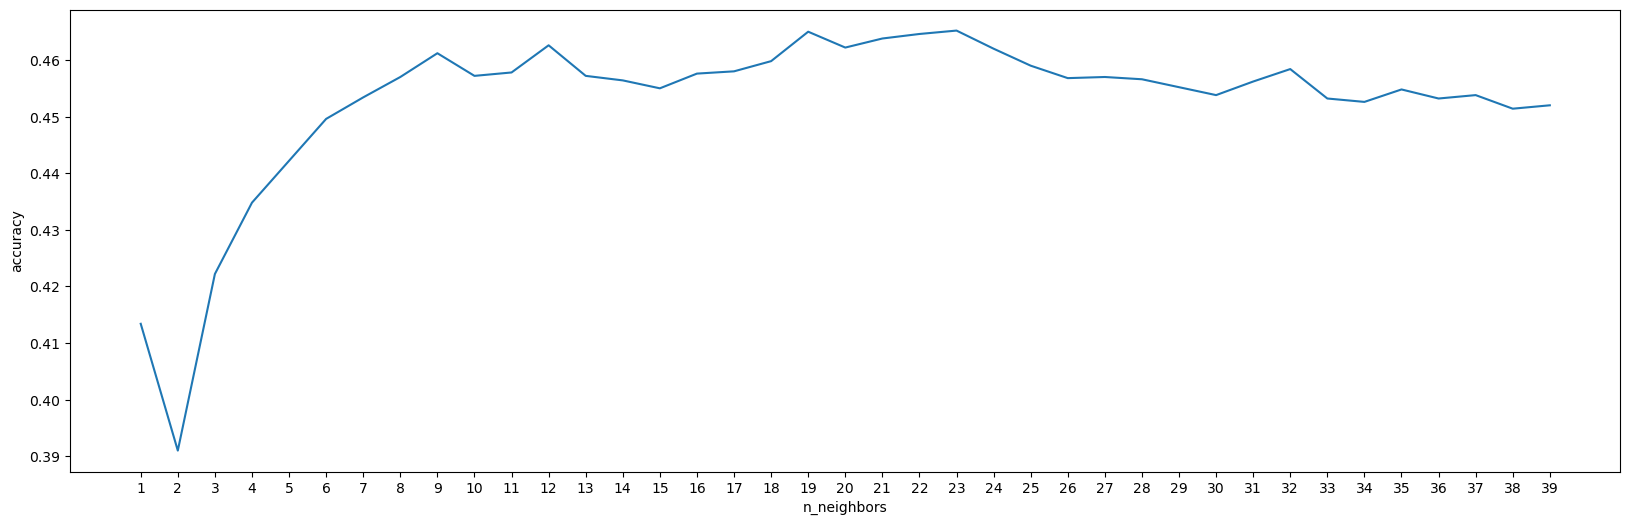

CPU times: total: 1min 59s
Wall time: 12.9 s


In [129]:
%%time

n_neighbors = range(1,40)
scores = list()

for n in n_neighbors:
    clf = KNeighborsClassifier(n_neighbors=n, metric="manhattan", weights="uniform")
    clf.fit(df_key_norm, y_train)
    scores.append(clf.score(test_key_norm, y_test))

fig = plt.figure(figsize=(20, 6))

plt.plot(scores)
plt.xticks(range(len(n_neighbors)), n_neighbors)
plt.xlabel("n_neighbors")
plt.ylabel("accuracy")
plt.show()

In [130]:
clf = KNeighborsClassifier(n_neighbors=17, metric="manhattan", weights="uniform")
clf.fit(df_key_norm, y_train)

KNeighborsClassifier(metric='manhattan', n_neighbors=17)

In [131]:
# predict: Predict the class labels for the provided data.
y_test_pred = clf.predict(test_key_norm)
y_test_pred

array(['industrial', 'techno', 'forro', ..., 'happy', 'black-metal',
       'happy'], dtype=object)

In [132]:
print("Accuracy:", accuracy_score(y_test, y_test_pred))

Accuracy: 0.458


#### With 'time_signature'

In [134]:
df_time = df.drop(['kmeans_labels', 'hierarchical_labels', 'dbscan_labels', 'hdbscan_labels', 'explicit', 'name', 'artists', 'album_name', 'genre', 'popularity_confidence', 'processing', 'key_0', 'key_1', 'key_2', 'key_3', 'key_4', 'key_5', 'key_6', 'key_7', 'key_8', 'key_9',  'key_10', 'key_11', 'features_duration_ms', 'n_beats', 'n_bars'], axis=1)

In [135]:
# one-hot encoding of categorical data
categorical_cols = ["time_signature"]
df_times = pd.get_dummies(df_time, columns=categorical_cols, dtype=int)

In [136]:
df_times

duration_ms  popularity  danceability  energy  loudness  mode  \
0           241760          46         0.690   0.513   -12.529   1.0   
1           444000           0         0.069   0.196   -24.801   0.0   
2           333506           3         0.363   0.854    -7.445   1.0   
3           269800          23         0.523   0.585    -5.607   1.0   
4           307651          25         0.643   0.687   -11.340   1.0   
...            ...         ...           ...     ...       ...   ...   
14995       432026           0         0.554   0.657   -14.232   0.5   
14996       182746          44         0.103   0.860   -19.627   1.0   
14997       400091          43         0.799   0.535    -9.103   1.0   
14998       197250          37         0.511   0.970    -2.299   1.0   
14999       198409          36         0.678   0.518    -7.790   1.0   

       speechiness  acousticness  instrumentalness  liveness  valence  \
0           0.0975      0.302000          0.536000    0.2810   0.6350   
1           0.0805      0.283000          0.934000    0.3600   0.0336   
2           0.0397      0.000089          0.800000    0.2620   0.4890   
3           0.0765      0.066400          0.001270    0.1170   0.3850   
4           0.0539      0.000576          0.096900    0.2990   0.6370   
...            ...           ...               ...       ...      ...   
14995       0.0558      0.016000          0.615000    0.1320   0.0335   
14996       0.0595      0.548000          0.940000    0.1230   0.0016   
14997       0.0594      0.001830          0.857000    0.0713   0.0708   
14998       0.0531      0.000337          0.000014    0.4020   0.2700   
14999       0.0352      0.463000          0.000000    0.0880   0.7840   

         tempo  time_signature_0.0  time_signature_1.0  time_signature_3.0  \
0      142.221                   0                   0                   0   
1       75.596                   0                   0                   0   
2      116.628                   0                   0                   0   
3      140.880                   0                   0                   0   
4      143.956                   0                   0                   0   
...        ...                 ...                 ...                 ...   
14995  117.319                   0                   0                   0   
14996   92.323                   0                   0                   1   
14997  126.000                   0                   0                   0   
14998  160.044                   0                   0                   0   
14999   88.003                   0                   0                   0   

       time_signature_4.0  time_signature_5.0  
0                       1                   0  
1                       1                   0  
2                       1                   0  
3                       1                   0  
4                       1                   0  
...                   ...                 ...  
14995                   1                   0  
14996                   0                   0  
14997                   1                   0  
14998                   1                   0  
14999                   1                   0  

[15000 rows x 17 columns]

In [137]:
#Normalization

scaler = StandardScaler()
scaler.fit(df_times)
df_time_norm = scaler.transform(df_times)

In [138]:
# one-hot encoding of categorical data
categorical_cols = ["time_signature"]
test_times = pd.get_dummies(test, columns=categorical_cols, dtype=int)

test_time = test_times.drop(['explicit', 'name', 'artists', 'album_name', 'genre', 'popularity_confidence', 'processing', 'key', 'features_duration_ms', 'n_beats', 'n_bars'], axis=1)

#Normalization for the test set WITH 'mode'

scaler = StandardScaler()
scaler.fit(test_time)
test_time_norm = scaler.transform(test_time)

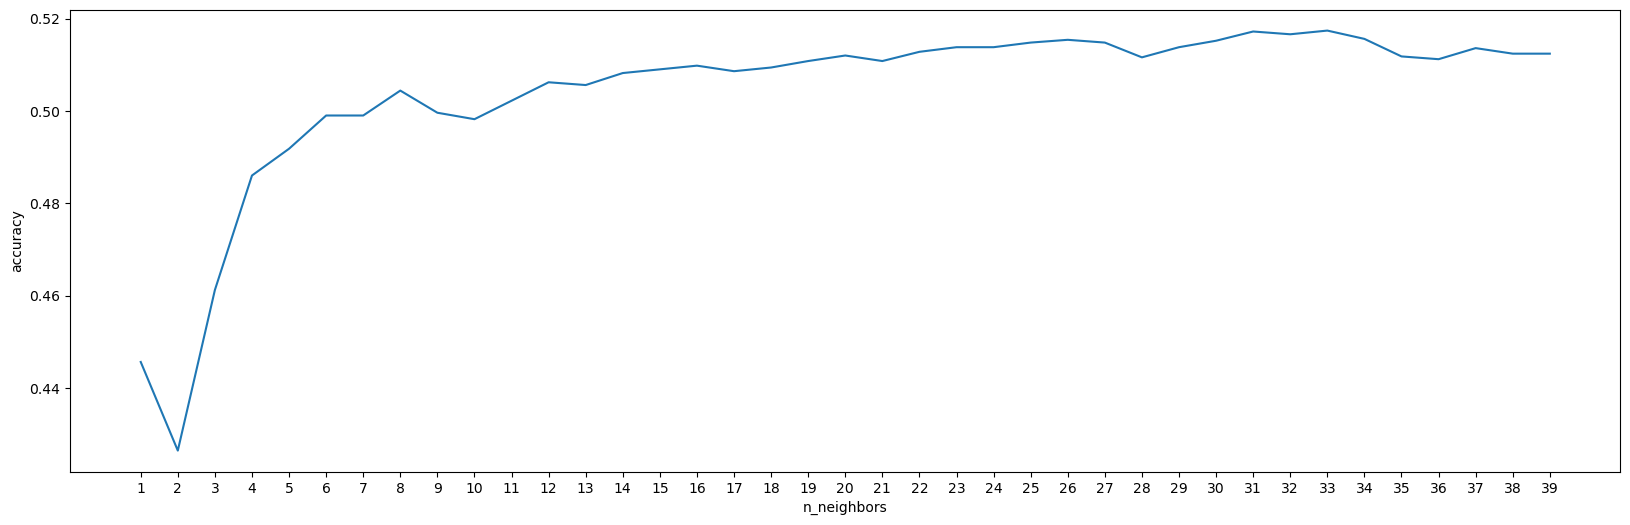

CPU times: total: 1min 45s
Wall time: 12.4 s


In [139]:
%%time

n_neighbors = range(1,40)
scores = list()

for n in n_neighbors:
    clf = KNeighborsClassifier(n_neighbors=n, metric="manhattan", weights="uniform")
    clf.fit(df_time_norm, y_train)
    scores.append(clf.score(test_time_norm, y_test))

fig = plt.figure(figsize=(20, 6))

plt.plot(scores)
plt.xticks(range(len(n_neighbors)), n_neighbors)
plt.xlabel("n_neighbors")
plt.ylabel("accuracy")
plt.show()

In [140]:
clf = KNeighborsClassifier(n_neighbors=33, metric="manhattan", weights="uniform")
clf.fit(df_time_norm, y_train)

KNeighborsClassifier(metric='manhattan', n_neighbors=33)

In [141]:
# predict: Predict the class labels for the provided data.
y_test_pred = clf.predict(test_time_norm)
y_test_pred

array(['j-idol', 'idm', 'mandopop', ..., 'j-idol', 'black-metal', 'happy'],
      dtype=object)

In [142]:
print("Accuracy:", accuracy_score(y_test, y_test_pred))

Accuracy: 0.5174


#### Clustering with 'key' and 'time_signature'

In [144]:


%%time
sse_list = []
sil_list = []

for k in range(2, 60):
    kmeans = KMeans(init='k-means++', n_clusters=k, n_init=10, max_iter=100)
    kmeans.fit(df_key_norm)
    sse_list.append(kmeans.inertia_)
    sil_list.append(silhouette_score(df_key_norm, kmeans.labels_))

CPU times: total: 6min 18s
Wall time: 2min 23s


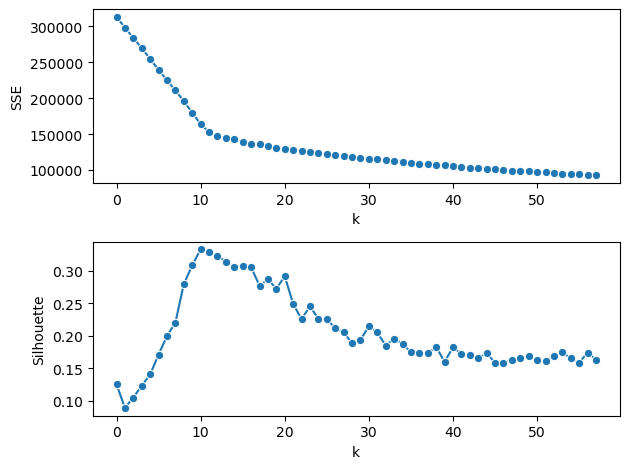

In [145]:
fig, axs = plt.subplots(2) 

sns.lineplot(x=range(len(sse_list)), y=sse_list, marker='o', ax=axs[0])
axs[0].set(xlabel='k', ylabel='SSE')

sns.lineplot(x=range(len(sil_list)), y=sil_list, marker='o', ax=axs[1])
axs[1].set(xlabel='k', ylabel='Silhouette')

plt.tight_layout() # Adjust the padding between and around subplots

10 clusters are best. Silhouette is higher by 0.1, but SSE is higher by 70.000

In [147]:
kmeans = KMeans(n_clusters=10, n_init=10, max_iter=100, random_state=94)
kmeans.fit(df_key_norm)

KMeans(max_iter=100, n_clusters=10, n_init=10, random_state=94)

In [148]:
my_sse = kmeans.inertia_
my_sse

196327.1642899965

In [149]:
N = 500
sse_stats = []

for _ in range(N):
    Xi = np.zeros(shape=df_key_norm.shape)
    
    for cidx in range(Xi.shape[1]):
        col = df_key_norm[:, cidx]
        min, max, nor = np.min(col), np.max(col), len(col)
        Xi[:, cidx] = np.random.uniform(min, max, (1, nor))
    
    kmeans = KMeans(n_clusters=11, n_init=10, max_iter=100, random_state=94)
    kmeans.fit(Xi)
    sse_stats.append(kmeans.inertia_)

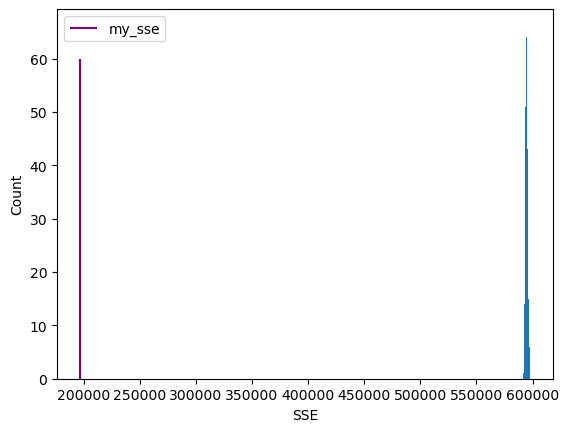

In [150]:
plt.hist(sse_stats, bins='auto')
plt.vlines(x = my_sse, ymin = 0, ymax = 60, colors = 'purple', label = 'my_sse')
plt.xlabel('SSE')
plt.ylabel('Count')
plt.legend()
plt.show()

In [151]:
df['kmeans_labels'] = kmeans.labels_

print('Silhouette', silhouette_score(df_key_norm, kmeans.labels_))

Silhouette -0.008033883792885452


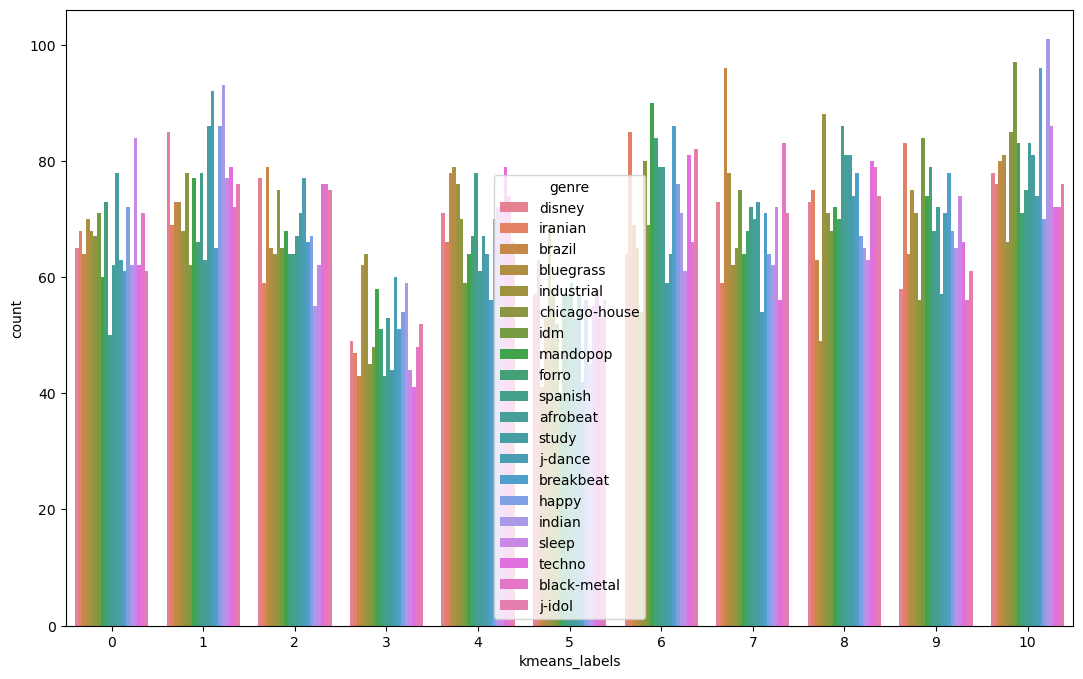

In [152]:
fig = plt.figure(figsize=(13, 8))

sns.countplot(data=df, x='kmeans_labels', hue='genre', )
plt.show()

In [153]:

df[df['kmeans_labels']==9].describe()
#mean duration: 2.468075e+05

duration_ms   popularity  danceability       energy     loudness  \
count  1.380000e+03  1380.000000   1380.000000  1380.000000  1380.000000   
mean   2.507635e+05    27.200000      0.549978     0.657497    -8.928085   
std    1.329099e+05    18.731506      0.195284     0.261129     6.101960   
min    3.550000e+04     0.000000      0.000000     0.000020   -43.943000   
25%    1.818385e+05    13.000000      0.441750     0.490500   -10.670750   
50%    2.286375e+05    24.000000      0.579500     0.704500    -7.258000   
75%    2.925918e+05    42.000000      0.694250     0.883000    -5.093250   
max    2.287542e+06    85.000000      0.947000     1.000000     0.123000   

              mode  speechiness  acousticness  instrumentalness     liveness  \
count  1380.000000  1380.000000   1380.000000       1380.000000  1380.000000   
mean      0.668116     0.082410      0.304362          0.284614     0.219979   
std       0.464764     0.088078      0.330487          0.381864     0.202870   
min       0.000000     0.000000      0.000000          0.000000     0.013700   
25%       0.000000     0.037300      0.009862          0.000000     0.098175   
50%       1.000000     0.049800      0.144000          0.002315     0.132000   
75%       1.000000     0.085125      0.561250          0.732250     0.288250   
max       1.000000     0.861000      0.996000          1.000000     0.989000   

       ...        key_2        key_3        key_4        key_5        key_6  \
count  ...  1380.000000  1380.000000  1380.000000  1380.000000  1380.000000   
mean   ...     0.095652     0.031884     0.068841     0.076087     0.071739   
std    ...     0.294220     0.175755     0.253275     0.265233     0.258149   
min    ...     0.000000     0.000000     0.000000     0.000000     0.000000   
25%    ...     0.000000     0.000000     0.000000     0.000000     0.000000   
50%    ...     0.000000     0.000000     0.000000     0.000000     0.000000   
75%    ...     0.000000     0.000000     0.000000     0.000000     0.000000   
max    ...     1.000000     1.000000     1.000000     1.000000     1.000000   

             key_7        key_8        key_9       key_10       key_11  
count  1380.000000  1380.000000  1380.000000  1380.000000  1380.000000  
mean      0.120290     0.064493     0.092029     0.084058     0.083333  
std       0.325418     0.245718     0.289172     0.277575     0.276486  
min       0.000000     0.000000     0.000000     0.000000     0.000000  
25%       0.000000     0.000000     0.000000     0.000000     0.000000  
50%       0.000000     0.000000     0.000000     0.000000     0.000000  
75%       0.000000     0.000000     0.000000     0.000000     0.000000  
max       1.000000     1.000000     1.000000     1.000000     1.000000  

[8 rows x 34 columns]

In [154]:
# setting distance_threshold=0 ensures we compute the full tree.
model_key = AgglomerativeClustering(distance_threshold=0,
                                n_clusters=None, metric='euclidean', linkage='complete')
model_key = model_2.fit(df_key_norm)

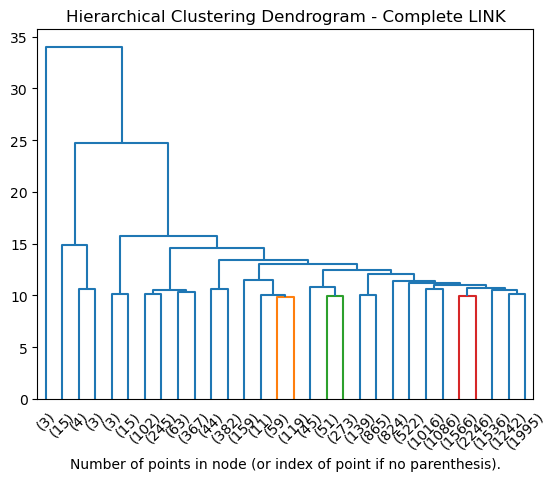

In [155]:
plt.title("Hierarchical Clustering Dendrogram - Complete LINK")
plot_dendrogram(model_key, truncate_mode="lastp", color_threshold=10)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [156]:
# get the labels according to a specific threshold value cut
Z_key = get_linkage_matrix(model_key)
labels_key = fcluster(Z_key, t=10, criterion='distance')

print('Silhouette', silhouette_score(df_key_norm, labels_key))

Silhouette 0.21101295789335042


In [157]:
%%time
sse_list = []
sil_list = []

for k in range(2, 60):
    kmeans = KMeans(init='k-means++', n_clusters=k, n_init=10, max_iter=100)
    kmeans.fit(df_time_norm)
    sse_list.append(kmeans.inertia_)
    sil_list.append(silhouette_score(df_time_norm, kmeans.labels_))

CPU times: total: 6min 16s
Wall time: 2min 27s


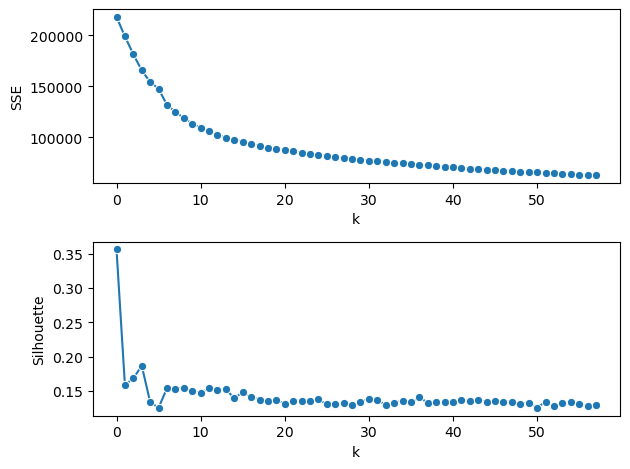

In [158]:
fig, axs = plt.subplots(2) 

sns.lineplot(x=range(len(sse_list)), y=sse_list, marker='o', ax=axs[0])
axs[0].set(xlabel='k', ylabel='SSE')

sns.lineplot(x=range(len(sil_list)), y=sil_list, marker='o', ax=axs[1])
axs[1].set(xlabel='k', ylabel='Silhouette')

plt.tight_layout() # Adjust the padding between and around subplots

Resembles a lot the one without 'time_signature' since most of the songs have the same value for that attribute, but creates additional distance for the ones that don't. The Silhouette is basically the same, but the SSE is greatly increased.

In [160]:
# setting distance_threshold=0 ensures we compute the full tree.
model_time = AgglomerativeClustering(distance_threshold=0,
                                n_clusters=None, metric='euclidean', linkage='complete')
model_time = model_2.fit(df_time_norm)

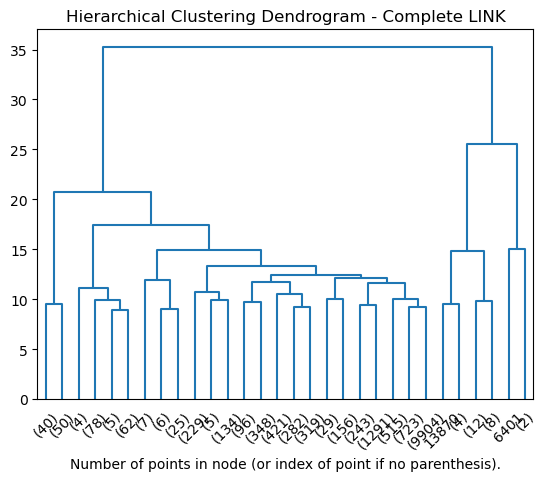

In [161]:
plt.title("Hierarchical Clustering Dendrogram - Complete LINK")
plot_dendrogram(model_time, truncate_mode="lastp", color_threshold=0)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [162]:
# get the labels according to a specific threshold value cut
Z_time = get_linkage_matrix(model_time)
labels_time = fcluster(Z_time, t=10, criterion='distance')

print('Silhouette', silhouette_score(df_time_norm, labels_time))

Silhouette 0.1837266959135126


The Silhouette score has increased (not as much as with 'key'), but the clusters are "worse" since one is already 10.000 elements, so 2/3 of the dataset.

# Naive Bayes

In [165]:
from sklearn.naive_bayes import GaussianNB, CategoricalNB

In [166]:
clf = GaussianNB()

In [167]:
%%time
clf.fit(df_exp_norm, y_train)

CPU times: total: 0 ns
Wall time: 16.5 ms


GaussianNB()

In [168]:
y_pred = clf.predict(test_exp_norm)
y_pred

array(['j-idol', 'techno', 'j-idol', ..., 'j-idol', 'black-metal',
       'happy'], dtype='<U13')

In [169]:
print(classification_report(y_test, y_pred))

               precision    recall  f1-score   support

     afrobeat       0.40      0.07      0.12       250
  black-metal       0.56      0.63      0.60       250
    bluegrass       0.41      0.42      0.41       250
       brazil       0.41      0.10      0.16       250
    breakbeat       0.24      0.10      0.14       250
chicago-house       0.39      0.68      0.49       250
       disney       0.00      0.00      0.00       250
        forro       0.39      0.60      0.47       250
        happy       0.39      0.30      0.34       250
          idm       0.46      0.28      0.35       250
       indian       0.24      0.04      0.06       250
   industrial       0.32      0.18      0.23       250
      iranian       0.53      0.25      0.34       250
      j-dance       0.46      0.62      0.53       250
       j-idol       0.24      0.77      0.37       250
     mandopop       0.26      0.80      0.39       250
        sleep       0.48      0.77      0.59       250
      spa

C:\Users\Utente\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Utente\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Utente\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


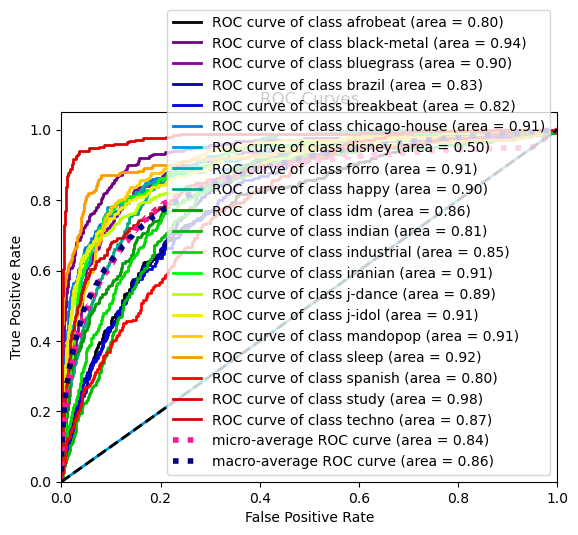

0.859849094736842


In [170]:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
plot_roc(y_test, clf.predict_proba(test_exp_norm))
plt.show()
print(roc_auc_score(y_test, clf.predict_proba(test_exp_norm), multi_class="ovr", average="macro"))

## Decision Tree

In [172]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [173]:
df_tree = df.drop(['hierarchical_labels', 'kmeans_labels', 'dbscan_labels', 'hdbscan_labels'], axis=1)
df_tree = df_tree.drop(['name', 'artists', 'album_name', 'features_duration_ms', 'genre', 'n_beats', 'n_bars', 'popularity_confidence', 'processing'], axis=1)
df_tree = df_tree.drop(['explicit'], axis=1)
df_tree.dtypes

duration_ms           int64
popularity            int64
danceability        float64
energy              float64
loudness            float64
mode                float64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
time_signature      float64
key_0                 int32
key_1                 int32
key_2                 int32
key_3                 int32
key_4                 int32
key_5                 int32
key_6                 int32
key_7                 int32
key_8                 int32
key_9                 int32
key_10                int32
key_11                int32
dtype: object

In [174]:
# one-hot encoding of categorical data
categorical_cols = ["time_signature"]
df_tree = pd.get_dummies(df_tree, columns=categorical_cols, dtype=int)

In [175]:
#Normalization

scaler = StandardScaler()
scaler.fit(df_tree)
df_tree_norm = scaler.transform(df_tree)

In [176]:
# one-hot encoding of categorical data
categorical_cols = ["time_signature"]
test_tree = pd.get_dummies(test, columns=categorical_cols, dtype=int)

test_tree = test_tree.drop(['explicit', 'name', 'artists', 'album_name', 'genre', 'popularity_confidence', 'processing', 'features_duration_ms', 'n_beats', 'n_bars'], axis=1)

categorical_cols = ["key"]
test_tree = pd.get_dummies(test_tree, columns=categorical_cols, dtype=int)

#Normalization for the test set WITH 'mode'

scaler = StandardScaler()
scaler.fit(test_tree)
test_tree_norm = scaler.transform(test_tree)

In [177]:
dt = DecisionTreeClassifier(min_samples_leaf=20, max_depth=11)#, min_samples_split=0.01)

In [178]:
%%time
dt.fit(df_tree_norm, y_train)

CPU times: total: 156 ms
Wall time: 159 ms


DecisionTreeClassifier(max_depth=11, min_samples_leaf=20)

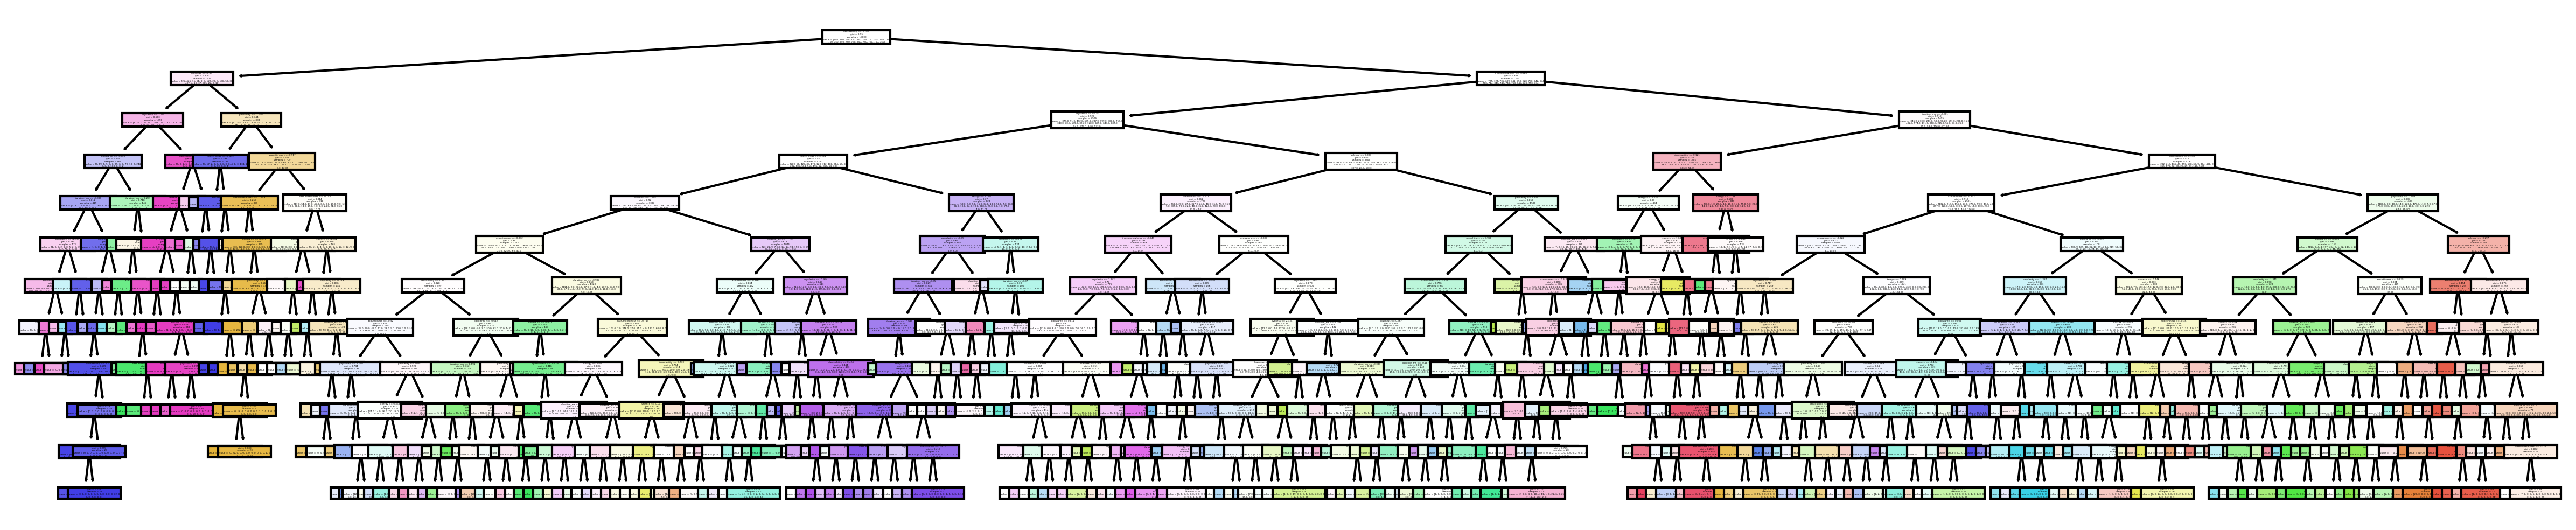

CPU times: total: 16.1 s
Wall time: 18.1 s


In [179]:
%%time

attributes = [col for col in df_tree.columns if col != 'genre']

plt.figure(figsize=(20, 4), dpi=300)
plot_tree(dt, feature_names=attributes, filled=True)
plt.show()

In [180]:
y_train_pred = dt.predict(df_tree_norm)
y_test_pred = dt.predict(test_tree_norm)

In [181]:
print('Train Accuracy %s' % accuracy_score(y_train, y_train_pred))
print('Train F1-score %s' % f1_score(y_train, y_train_pred, average=None))
print()

print('Test Accuracy %s' % accuracy_score(y_test, y_test_pred))
print('Test F1-score %s' % f1_score(y_test, y_test_pred, average=None))

Train Accuracy 0.5593333333333333
Train F1-score [0.39486814 0.75032852 0.55184744 0.45974026 0.42289562 0.64532985
 0.52638889 0.63791923 0.54188948 0.45889387 0.45544554 0.42501518
 0.69910371 0.56540698 0.59832954 0.51435705 0.81651997 0.39447732
 0.77155444 0.54379284]

Test Accuracy 0.4426
Test F1-score [0.24255319 0.61865794 0.4400607  0.23350254 0.29583333 0.58682635
 0.41318681 0.55130785 0.39922481 0.35244161 0.30275229 0.2955665
 0.58802817 0.50112867 0.4784689  0.28423773 0.72807018 0.30222222
 0.70699433 0.4537037 ]


In [182]:
print(classification_report(y_test, y_test_pred))

               precision    recall  f1-score   support

     afrobeat       0.26      0.23      0.24       250
  black-metal       0.52      0.76      0.62       250
    bluegrass       0.35      0.58      0.44       250
       brazil       0.32      0.18      0.23       250
    breakbeat       0.31      0.28      0.30       250
chicago-house       0.59      0.59      0.59       250
       disney       0.46      0.38      0.41       250
        forro       0.55      0.55      0.55       250
        happy       0.39      0.41      0.40       250
          idm       0.38      0.33      0.35       250
       indian       0.25      0.40      0.30       250
   industrial       0.25      0.36      0.30       250
      iranian       0.53      0.67      0.59       250
      j-dance       0.58      0.44      0.50       250
       j-idol       0.60      0.40      0.48       250
     mandopop       0.40      0.22      0.28       250
        sleep       0.81      0.66      0.73       250
      spa

In [183]:
zipped = zip(attributes, dt.feature_importances_)
zipped = sorted(zipped, key=lambda x: x[1], reverse=True)
for col, imp in zipped:
    print(col, imp)

popularity 0.23727669309059185
duration_ms 0.1332064632088018
danceability 0.12587751804557143
acousticness 0.11901027322132755
instrumentalness 0.08070505776251247
loudness 0.08028920239894151
valence 0.07249088287586042
speechiness 0.05126931033620829
energy 0.04967551566430806
tempo 0.03968121804261908
liveness 0.01050413961928342
key_7 1.372573397413149e-05
mode 0.0
key_0 0.0
key_1 0.0
key_2 0.0
key_3 0.0
key_4 0.0
key_5 0.0
key_6 0.0
key_8 0.0
key_9 0.0
key_10 0.0
key_11 0.0
time_signature_0.0 0.0
time_signature_1.0 0.0
time_signature_3.0 0.0
time_signature_4.0 0.0
time_signature_5.0 0.0


This values show us that the 'key' and 'time_signature' attributes, used with the boolean matrix, are considered last in the algorithm for the decision tree

#### Trying using 'key' and 'time_signature' as they were originally

In [186]:
df_tree_or = pd.read_csv('datasets/train.csv')

df_tree_or = df_tree_or.drop(['name', 'artists', 'album_name', 'features_duration_ms', 'genre', 'n_beats', 'n_bars', 'popularity_confidence', 'processing'], axis=1)
df_tree_or.dtypes

duration_ms           int64
explicit               bool
popularity            int64
danceability        float64
energy              float64
key                   int64
loudness            float64
mode                float64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
time_signature      float64
dtype: object

In [187]:
test_tree_or = pd.read_csv('datasets/test.csv')

test_tree_or = test_tree_or.drop(['name', 'artists', 'album_name', 'features_duration_ms', 'genre', 'n_beats', 'n_bars', 'popularity_confidence', 'processing'], axis=1)
test_tree_or.dtypes

duration_ms           int64
explicit               bool
popularity            int64
danceability        float64
energy              float64
key                   int64
loudness            float64
mode                float64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
time_signature      float64
dtype: object

In [188]:
#Normalization

scaler = StandardScaler()
scaler.fit(df_tree_or)
df_tree_or_norm = scaler.transform(df_tree_or)

In [189]:
#Normalization

scaler = StandardScaler()
scaler.fit(test_tree_or)
test_tree_or_norm = scaler.transform(test_tree_or)

In [190]:
dt = DecisionTreeClassifier()#max_depth=12, min_samples_split=0.002, min_samples_leaf=20)

In [191]:
%%time
dt.fit(df_tree_or_norm, y_train)

CPU times: total: 125 ms
Wall time: 197 ms


DecisionTreeClassifier()

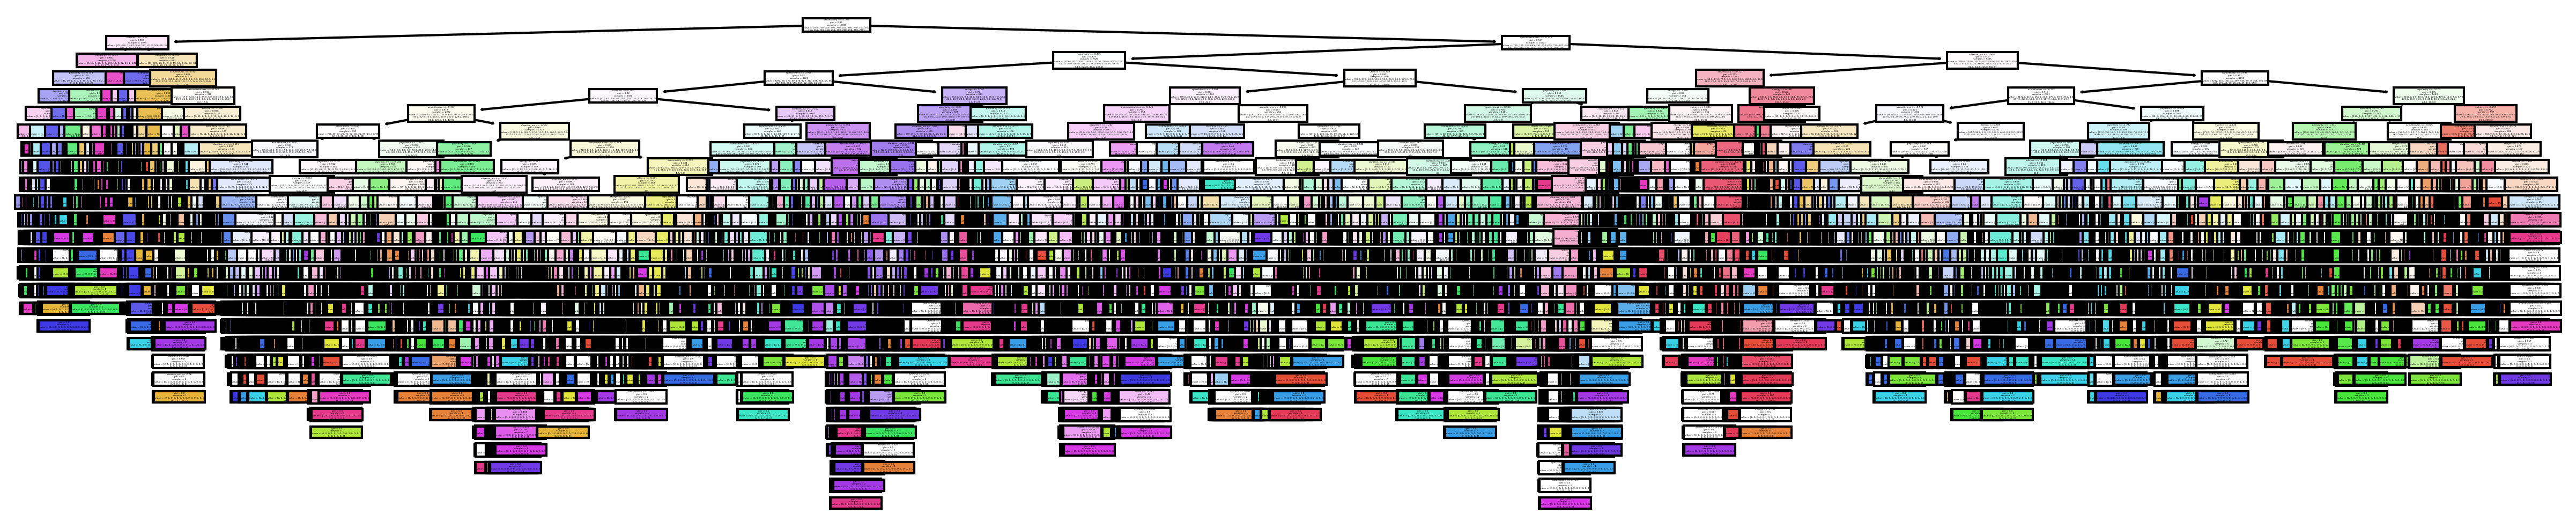

CPU times: total: 2min 50s
Wall time: 3min 14s


In [192]:
%%time

attributes = [col for col in df_tree_or.columns if col != 'genre']

plt.figure(figsize=(20, 4), dpi=300)
plot_tree(dt, feature_names=attributes, filled=True)
plt.show()

In [193]:
y_train_pred = dt.predict(df_tree_or_norm)
y_test_pred = dt.predict(test_tree_or_norm)

In [194]:
print('Train Accuracy %s' % accuracy_score(y_train, y_train_pred))
print('Train F1-score %s' % f1_score(y_train, y_train_pred, average=None))
print()

print('Test Accuracy %s' % accuracy_score(y_test, y_test_pred))
print('Test F1-score %s' % f1_score(y_test, y_test_pred, average=None))

Train Accuracy 0.9968
Train F1-score [0.99332443 0.99933378 0.99667332 0.99533022 0.99800133 0.99800133
 0.99466667 0.99866844 0.99933378 0.99331551 0.99330656 0.99666444
 0.99933289 0.99800133 0.99733688 0.99534265 0.99866489 0.99733333
 0.99666889 0.99666889]

Test Accuracy 0.407
Test F1-score [0.23779193 0.6179402  0.42045455 0.24463519 0.28290766 0.53012048
 0.44820296 0.47357294 0.32618026 0.31060606 0.30371567 0.25963489
 0.51550388 0.46902655 0.39240506 0.25174825 0.7375     0.19483101
 0.71342685 0.37236084]


In [195]:
print(classification_report(y_test, y_test_pred))

               precision    recall  f1-score   support

     afrobeat       0.25      0.22      0.24       250
  black-metal       0.53      0.74      0.62       250
    bluegrass       0.40      0.44      0.42       250
       brazil       0.26      0.23      0.24       250
    breakbeat       0.28      0.29      0.28       250
chicago-house       0.53      0.53      0.53       250
       disney       0.48      0.42      0.45       250
        forro       0.50      0.45      0.47       250
        happy       0.35      0.30      0.33       250
          idm       0.29      0.33      0.31       250
       indian       0.25      0.38      0.30       250
   industrial       0.26      0.26      0.26       250
      iranian       0.50      0.53      0.52       250
      j-dance       0.52      0.42      0.47       250
       j-idol       0.42      0.37      0.39       250
     mandopop       0.30      0.22      0.25       250
        sleep       0.77      0.71      0.74       250
      spa

In [196]:
zipped_or = zip(attributes, dt.feature_importances_)
zipped_or = sorted(zipped_or, key=lambda x: x[1], reverse=True)
for col, imp in zipped_or:
    print(col, imp)

popularity 0.145459861095983
duration_ms 0.11180598144959449
danceability 0.0970235305060252
acousticness 0.09667258975924765
loudness 0.09008766684009085
valence 0.08051352233189195
tempo 0.07215274722316974
instrumentalness 0.06841332713418788
speechiness 0.06818622556860848
energy 0.06510788581705013
liveness 0.049317392211494435
key 0.028412061629836127
mode 0.013581583226131462
time_signature 0.007742376857291749
explicit 0.005523248349396884


The accuracy has overall gone down, so using the boolean matrix is still better than this, even though the attributes were not highly valued.

Now the same but without 'mode', since it was an attribute with missing values, so it is possible that the values we used to fill the gaps are not correct and skew the model. But it was not highly valued in the algorithm, so the results do not vary

In [199]:
df_tree_or = df_tree_or.drop(['explicit', 'liveness', 'mode', 'key', 'time_signature'], axis=1)
df_tree_or.dtypes

duration_ms           int64
popularity            int64
danceability        float64
energy              float64
loudness            float64
speechiness         float64
acousticness        float64
instrumentalness    float64
valence             float64
tempo               float64
dtype: object

In [200]:
test_tree_or = test_tree_or.drop(['explicit', 'liveness', 'mode', 'key', 'time_signature'], axis=1)
test_tree_or.dtypes

duration_ms           int64
popularity            int64
danceability        float64
energy              float64
loudness            float64
speechiness         float64
acousticness        float64
instrumentalness    float64
valence             float64
tempo               float64
dtype: object

In [201]:
#Normalization

scaler = StandardScaler()
scaler.fit(df_tree_or)
df_tree_or_norm2 = scaler.transform(df_tree_or)

In [202]:
#Normalization

scaler = StandardScaler()
scaler.fit(test_tree_or)
test_tree_or_norm2 = scaler.transform(test_tree_or)

In [203]:
dt = DecisionTreeClassifier(min_samples_leaf=15, min_samples_split=0.003)

In [204]:
dt.fit(df_tree_or_norm2, y_train)

DecisionTreeClassifier(min_samples_leaf=15, min_samples_split=0.003)

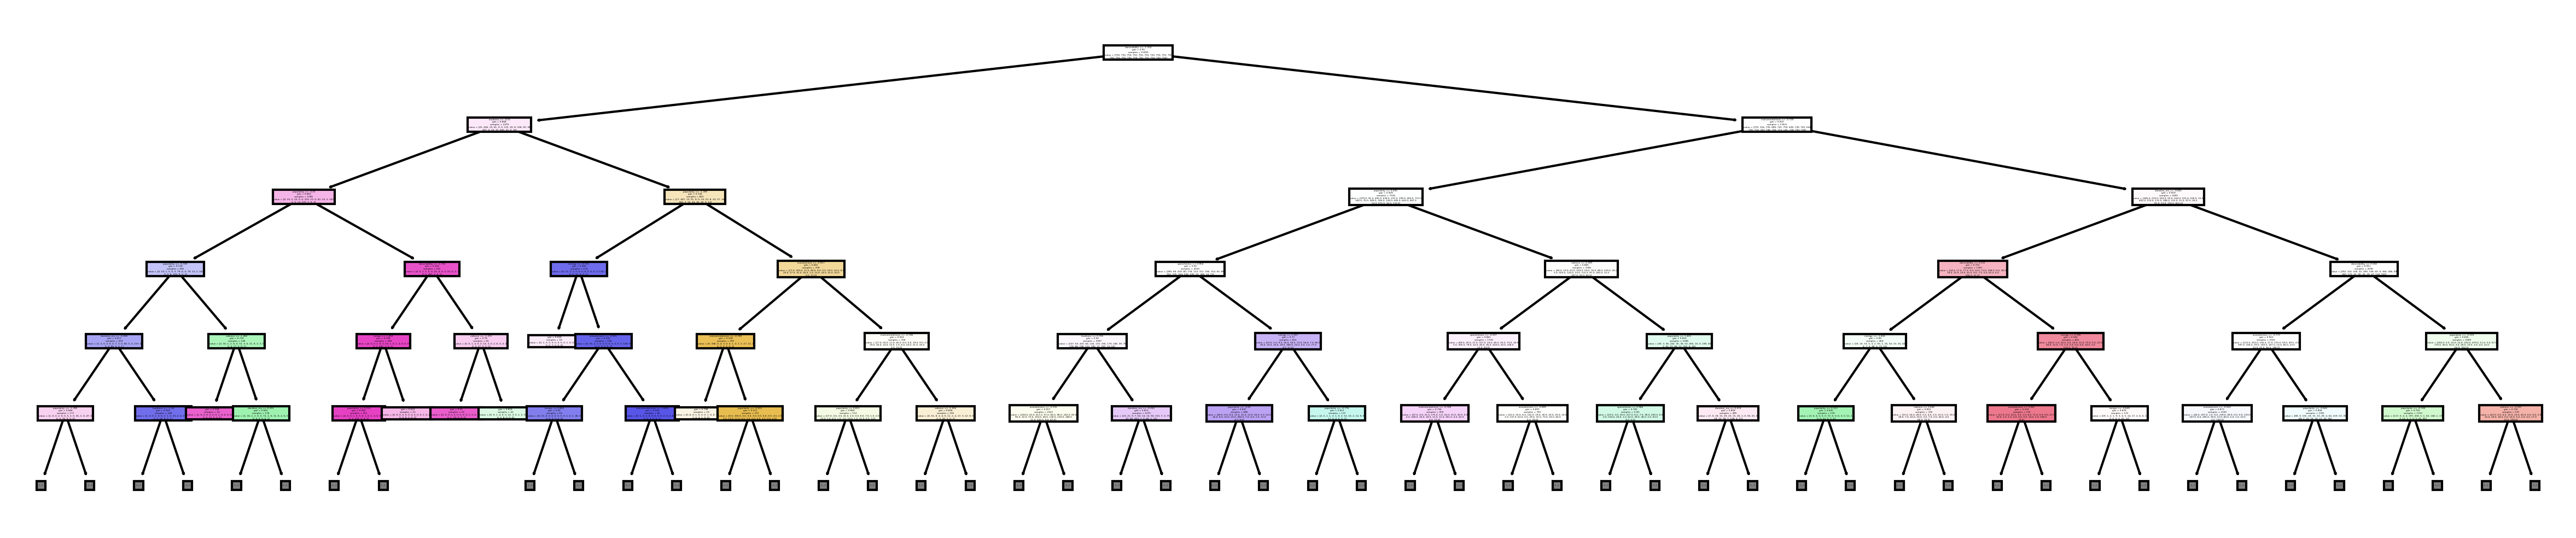

CPU times: total: 2.62 s
Wall time: 2.86 s


In [205]:
%%time

attributes = [col for col in df_tree_or.columns if col != 'genre']

plt.figure(figsize=(20, 4), dpi=300)
plot_tree(dt, feature_names=attributes, filled=True, max_depth=5)
plt.show()

In [206]:
y_train_pred = dt.predict(df_tree_or_norm2)
y_test_pred = dt.predict(test_tree_or_norm2)

In [207]:
print('Train Accuracy %s' % accuracy_score(y_train, y_train_pred))
print('Train F1-score %s' % f1_score(y_train, y_train_pred, average=None))
print()

print('Test Accuracy %s' % accuracy_score(y_test, y_test_pred))
print('Test F1-score %s' % f1_score(y_test, y_test_pred, average=None))

Train Accuracy 0.5808
Train F1-score [0.42821159 0.74462705 0.61886792 0.49685973 0.43496215 0.65228426
 0.55003313 0.6569729  0.55483871 0.48063128 0.45053476 0.48230668
 0.69802924 0.58002736 0.60869565 0.55344262 0.82735274 0.42229965
 0.78210863 0.55166932]

Test Accuracy 0.4438
Test F1-score [0.26642336 0.61093248 0.48161765 0.23650386 0.30508475 0.55319149
 0.42213115 0.55144033 0.37394958 0.38075314 0.2887538  0.29845626
 0.56887299 0.51709402 0.50107066 0.30804598 0.72649573 0.26470588
 0.71290944 0.44337349]


In [208]:
print(classification_report(y_test, y_test_pred))

               precision    recall  f1-score   support

     afrobeat       0.24      0.29      0.27       250
  black-metal       0.51      0.76      0.61       250
    bluegrass       0.45      0.52      0.48       250
       brazil       0.33      0.18      0.24       250
    breakbeat       0.32      0.29      0.31       250
chicago-house       0.54      0.57      0.55       250
       disney       0.43      0.41      0.42       250
        forro       0.57      0.54      0.55       250
        happy       0.39      0.36      0.37       250
          idm       0.40      0.36      0.38       250
       indian       0.23      0.38      0.29       250
   industrial       0.26      0.35      0.30       250
      iranian       0.51      0.64      0.57       250
      j-dance       0.56      0.48      0.52       250
       j-idol       0.54      0.47      0.50       250
     mandopop       0.36      0.27      0.31       250
        sleep       0.78      0.68      0.73       250
      spa

In [209]:
zipped_or2 = zip(attributes, dt.feature_importances_)
zipped_or2 = sorted(zipped_or2, key=lambda x: x[1], reverse=True)
for col, imp in zipped_or2:
    print(col, imp)

popularity 0.23303372134065733
duration_ms 0.12900883874569785
danceability 0.12570101352667337
acousticness 0.1136644331085804
loudness 0.08318451792530969
instrumentalness 0.07849209919119765
valence 0.07654859122922814
speechiness 0.05685980467953813
energy 0.05600788389266051
tempo 0.04749909636045702


Dropping 'mode' improved slightly the accuracy all over the board, even though just by 0.01. The attribute 'explicit' proves not to be too useful, since it is the last discriminant for the algorithm.

Also to be note: using 'entropy' as the criterion instead of 'gini', the accuracy scores slightly decrease everywhere, both for the train accuracy and for the test accuracy.



#### Hyperparameters tuning

In [212]:
from sklearn.model_selection import cross_val_score

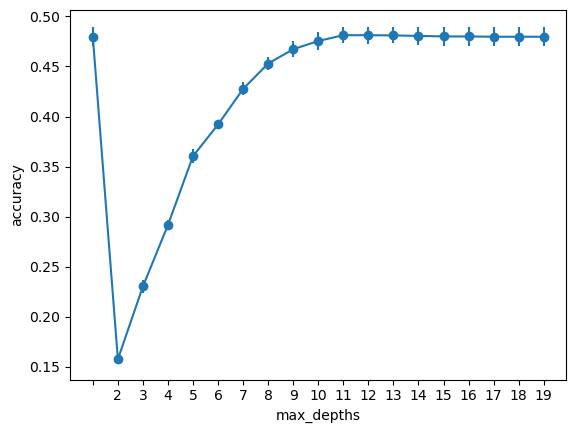

In [213]:
max_depths = [None] + list(np.arange(2, 20))
avg_scores = list()
std_scores = list()

for max_depth in max_depths:
    dt = DecisionTreeClassifier(min_samples_leaf = 15, min_samples_split=0.003, max_depth=max_depth)
    scores = cross_val_score(dt, df_tree_or_norm2, y_train, cv=5)
    avg_scores.append(np.mean(scores))
    std_scores.append(np.std(scores))

plt.errorbar(range(len(max_depths)), y=avg_scores, yerr=std_scores, marker='o')
plt.xticks(range(len(max_depths)), max_depths)
plt.xlabel("max_depths")
plt.ylabel("accuracy")
plt.show()

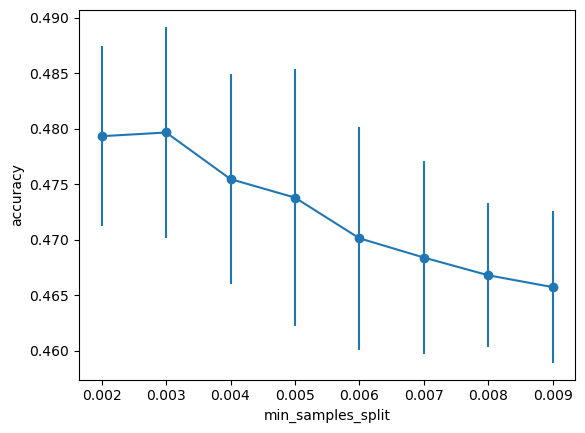

In [214]:
min_samples_splits = [0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009]
avg_scores = list()
std_scores = list()

for min_samples_split in min_samples_splits:
    dt = DecisionTreeClassifier(min_samples_leaf = 15, min_samples_split=min_samples_split)
    scores = cross_val_score(dt, df_tree_or_norm2, y_train, cv=5)
    avg_scores.append(np.mean(scores))
    std_scores.append(np.std(scores))

plt.errorbar(range(len(min_samples_splits)), y=avg_scores, yerr=std_scores, marker='o')
plt.xticks(range(len(min_samples_splits)), min_samples_splits)
plt.xlabel("min_samples_split")
plt.ylabel("accuracy")
plt.show()

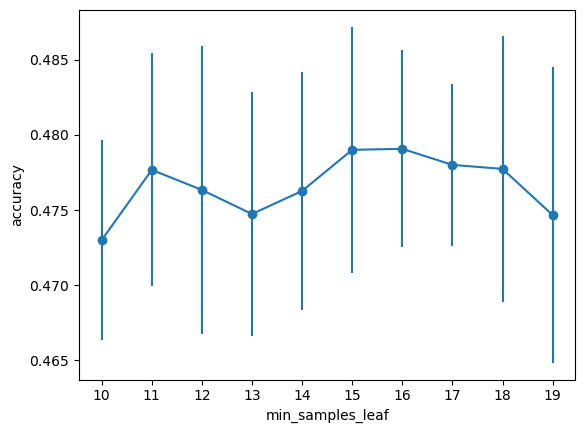

In [215]:
min_samples_leafs = [10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
avg_scores = list()
std_scores = list()

for min_samples_leaf in min_samples_leafs:
    dt = DecisionTreeClassifier(min_samples_leaf=min_samples_leaf)
    scores = cross_val_score(dt, df_tree_or_norm2, y_train, cv=5)
    avg_scores.append(np.mean(scores))
    std_scores.append(np.std(scores))

plt.errorbar(range(len(min_samples_leafs)), y=avg_scores, yerr=std_scores, marker='o')
plt.xticks(range(len(min_samples_leafs)), min_samples_leafs)
plt.xlabel("min_samples_leaf")
plt.ylabel("accuracy")
plt.show()

The best results are:
    
    for predicting only the 'test': df_tree_or_norm2 with 0.45
    
    combining all 'train' and 'test': df_tree_or_norm2 with 0.6529 and 0.4466, combining for 0.6013

Note: df_tree_or_norm2 is the one without 'mode', 'key' and 'time_signature'.

Later note: dropping 'explicit' and 'liveness', that are the two least important attributes for the algorithm of the remainig ones, and the accuracy , with min_samples_leaf=10, improves to 0.4546 for test and 0.6354 for train.

## Cross-Validation

In [218]:
from sklearn.model_selection import cross_val_score
k = 10

In [219]:
n_neighbors = range(1,40)

for n in n_neighbors:

# initialize classifier
    clf = KNeighborsClassifier(n_neighbors=n, metric="manhattan", weights="uniform")

    scores = cross_val_score(clf, df_exp_norm, y_train, cv=k)
    print(scores)
    

[0.49       0.47066667 0.45466667 0.46066667 0.454      0.46066667
 0.46266667 0.47066667 0.45666667 0.468     ]
[0.47       0.452      0.44266667 0.45533333 0.42533333 0.448
 0.45533333 0.44933333 0.45866667 0.458     ]
[0.492      0.48133333 0.48       0.47933333 0.45933333 0.48533333
 0.49       0.49733333 0.488      0.488     ]
[0.516      0.50333333 0.49733333 0.49266667 0.48266667 0.506
 0.49666667 0.51066667 0.502      0.49533333]
[0.532      0.51       0.51266667 0.50266667 0.502      0.50666667
 0.498      0.52133333 0.51266667 0.516     ]
[0.54333333 0.51666667 0.512      0.512      0.502      0.51733333
 0.50666667 0.52733333 0.51933333 0.53      ]
[0.544      0.518      0.52333333 0.514      0.50266667 0.522
 0.50666667 0.52733333 0.51733333 0.53666667]
[0.54733333 0.51866667 0.52333333 0.518      0.49666667 0.53266667
 0.51266667 0.53466667 0.51733333 0.538     ]
[0.54266667 0.52466667 0.52466667 0.516      0.504      0.532
 0.51666667 0.536      0.524      0.54866667]
[0.

We obtained the best scores with n=24, and, as shown below, it has an accuracy of 0.5346 on the train, while (as seen before, even though it should have been after) on the test the accuracy is 0.5436.

In [221]:
clf = GaussianNB()

scores = cross_val_score(clf, df_time_norm, y_train, cv=k)
scores

array([0.186     , 0.18666667, 0.196     , 0.19066667, 0.18      ,
       0.17466667, 0.178     , 0.18333333, 0.17866667, 0.168     ])

In [222]:
print("Overall error estimate:", 1 - scores.mean())

Overall error estimate: 0.8178


In [223]:
print('Accuracy: %0.4f (+/- %0.2f)' % (scores.mean(), scores.std()))

Accuracy: 0.1822 (+/- 0.01)


In [224]:
# scoring default is accuracy
cross_val_score(clf, df_exp_norm, y_train, cv=k, scoring='f1_macro')

array([0.20416248, 0.1970216 , 0.18584491, 0.19575303, 0.18249975,
       0.18589634, 0.20439742, 0.19215662, 0.19103298, 0.2155447 ])

With 'manhattan' distance the accuracy improves!

The following graph is for kNN on the train, but as expected the accuracy goes down as n grows.

In [ ]:
%%time

n_neighbors = range(1,40)
scores = list()

for n in n_neighbors:
    clf = KNeighborsClassifier(n_neighbors=n, metric="manhattan", weights="uniform")
    clf.fit(df_time_norm, y_train)
    scores.append(clf.score(df_time_norm, y_train))

fig = plt.figure(figsize=(20, 6))

plt.plot(scores)
plt.xticks(range(len(n_neighbors)), n_neighbors)
plt.xlabel("n_neighbors")
plt.ylabel("accuracy")
plt.show()

# Regression

For regression we will look at 'energy' and 'danceability' using linear, ridge, lasso, decision tree and kNN. The expectation is that, having those a 'more linear' relation (correlation of circa 0.7), the best regressors will be linear.

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso

In [ ]:
df_train = pd.read_csv('datasets/train.csv')
df_test = pd.read_csv('datasets/test.csv')

x_train = df_train["acousticness"].values.reshape(-1, 1)
y_train = df_train["energy"].values

x_test = df_test["acousticness"].values.reshape(-1, 1)
y_test = df_test["energy"].values

### Linear

In [ ]:
reg = LinearRegression()
reg.fit(x_train, y_train)

In [ ]:
print('Coefficients: \n', reg.coef_)
print('Intercept: \n', reg.intercept_)

In [ ]:
sns.scatterplot(data=df_train, x="acousticness", y="energy")
plt.plot(x_train, reg.coef_[0]*x_train+reg.intercept_, c="red")

In [ ]:
y_pred = reg.predict(x_test)

print('R2: %.3f' % r2_score(y_test, y_pred))
print('MSE: %.3f' % mean_squared_error(y_test, y_pred))
print('MAE: %.3f' % mean_absolute_error(y_test, y_pred))

In [ ]:
sns.scatterplot(data=df_test, x="acousticness", y="energy")
plt.plot(x_test, reg.coef_[0]*x_test+reg.intercept_, c="red")

In [ ]:
coefficients = reg.coef_
x_train=pd.DataFrame(x_train, columns=['acousticness'])
feature_names = x_train.columns
summary_df = pd.DataFrame({'Feature':feature_names, 'Coefficient':coefficients})
summary_df

### Ridge

In [ ]:
reg = Ridge()
reg.fit(x_train, y_train)
print('Coefficients: \n', reg.coef_)
print('Intercept: \n', reg.intercept_)

In [ ]:
sns.scatterplot(data=df_train, x="acousticness", y="energy")
plt.plot(x_train, reg.coef_[0]*x_train+reg.intercept_, c="red")

In [ ]:
y_pred = reg.predict(x_test)

print('R2: %.3f' % r2_score(y_test, y_pred))
print('MSE: %.3f' % mean_squared_error(y_test, y_pred))
print('MAE: %.3f' % mean_absolute_error(y_test, y_pred))

### Lasso

In [ ]:
reg = Lasso()
reg.fit(x_train, y_train)
print('Coefficients: \n', reg.coef_)
print('Intercept: \n', reg.intercept_)

In [ ]:
sns.scatterplot(data=df_train, x="acousticness", y="energy")
plt.plot(x_train, reg.coef_[0]*x_train+reg.intercept_, c="red")

In [ ]:
y_pred = reg.predict(x_test)

print('R2: %.3f' % r2_score(y_test, y_pred))
print('MSE: %.3f' % mean_squared_error(y_test, y_pred))
print('MAE: %.3f' % mean_absolute_error(y_test, y_pred))

### Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeRegressor

In [ ]:
reg = DecisionTreeRegressor()
reg.fit(x_train, y_train)

y_pred = reg.predict(x_test)
print('R2: %.3f' % r2_score(y_test, y_pred))
print('MSE: %.3f' % mean_squared_error(y_test, y_pred))
print('MAE: %.3f' % mean_absolute_error(y_test, y_pred))

In [ ]:
sns.scatterplot(data=df_train, x="acousticness", y="energy", label="True")
sns.scatterplot(data=df_train, x="acousticness", y=reg.predict(x_train), label="Predicted", marker="X")
plt.legend()
plt.show()

### kNN

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

In [ ]:
reg = KNeighborsRegressor()
reg.fit(x_train, y_train)

y_pred = reg.predict(x_test)
print('R2: %.3f' % r2_score(y_test, y_pred))
print('MSE: %.3f' % mean_squared_error(y_test, y_pred))
print('MAE: %.3f' % mean_absolute_error(y_test, y_pred))

In [ ]:
sns.scatterplot(data=df_train, x="acousticness", y="energy", label="True")
sns.scatterplot(data=df_train, x="acousticness", y=reg.predict(x_train), label="Predicted", marker="X")
plt.legend()
plt.show()

             R2          MSE             MAE
    Linear   0.501       0.035           0.149                           
    Ridge    0.501       0.035           0.149                          
    Lasso   -0.001       0.071           0.222                           
    DT       0.425       0.040           0.155                                                          
    kNN      0.440       0.039           0.154                        

Linear and Ridge seems to be the two best (since they have the highest R2 and lowest MSE and MAE), even though looking at the graphics the two non linear regressors (decision tree and kNN) seem better.

## Multiple Regression

In [ ]:
X_train = df_train[["acousticness", "loudness"]].values
y_train = df_train["energy"].values

X_test = df_test[["acousticness", "loudness"]].values
y_test = df_test["energy"].values


### Linear 

In [ ]:
reg = LinearRegression()
reg.fit(X_train, y_train)

In [ ]:
y_pred = reg.predict(X_test)
print('R2: %.3f' % r2_score(y_test, y_pred))
print('MSE: %.3f' % mean_squared_error(y_test, y_pred))
print('MAE: %.3f' % mean_absolute_error(y_test, y_pred))

In [ ]:
sns.scatterplot(data=df_test, x="acousticness", y="energy", label="True")
sns.scatterplot(data=df_test, x="acousticness", y=reg.predict(X_test), label="Predicted", marker="X")
plt.legend()
plt.show()

### Decision Tree

In [ ]:
reg = DecisionTreeRegressor()
reg.fit(X_train, y_train)

y_pred = reg.predict(X_test)
print('R2: %.3f' % r2_score(y_test, y_pred))
print('MSE: %.3f' % mean_squared_error(y_test, y_pred))
print('MAE: %.3f' % mean_absolute_error(y_test, y_pred))

In [ ]:
sns.scatterplot(data=df_test, x="acousticness", y="energy", label="True")
sns.scatterplot(data=df_test, x="acousticness", y=reg.predict(X_test), label="Predicted", marker="X")
plt.legend()
plt.show()

                 R2            MSE            MAE      
     Linear      0.661         0.024          0.118          
     DT          0.441         0.039          0.142      
                                    

## Multivariate

In [ ]:
X_train = df_train[["acousticness", "loudness"]].values
y_train = df_train[["energy", "instrumentalness"]].values

X_test = df_test[["acousticness", "loudness"]].values
y_test = df_test[["energy", "instrumentalness"]].values

In [ ]:
reg = DecisionTreeRegressor()
reg.fit(X_train, y_train)

y_pred = reg.predict(X_test)
print('R2: %.3f' % r2_score(y_test, y_pred))
print('MSE: %.3f' % mean_squared_error(y_test, y_pred))
print('MAE: %.3f' % mean_absolute_error(y_test, y_pred))

In [ ]:
y_pred = reg.predict(X_test)
y_pred

In [ ]:
sns.scatterplot(data=df_test, x="acousticness", y="energy", label="True")
sns.scatterplot(data=df_test, x="acousticness", y=reg.predict(X_test)[:, 0], label="Predicted", marker="X")
plt.legend()
plt.show()


In [ ]:
sns.scatterplot(data=df_test, x="loudness", y="instrumentalness", label="True")
sns.scatterplot(data=df_test, x="loudness", y=reg.predict(X_test)[:, 1], label="Predicted", marker="X")
plt.legend()
plt.show()

For regression we will look at 'instrumentalness' and 'speechiness' using linear, ridge, lasso, decision tree and kNN. The expectation is that, having those a 'less linear' relation (correlation of circa 0.1), the best regressors will be non-linear.

In [ ]:
df_train = pd.read_csv('datasets/train.csv')
df_test = pd.read_csv('datasets/test.csv')

x_train = df_train["instrumentalness"].values.reshape(-1, 1)
y_train = df_train["speechiness"].values

x_test = df_test["instrumentalness"].values.reshape(-1, 1)
y_test = df_test["speechiness"].values

### Linear

In [ ]:
reg = LinearRegression()
reg.fit(x_train, y_train)

In [ ]:
print('Coefficients: \n', reg.coef_)
print('Intercept: \n', reg.intercept_)

In [ ]:
sns.scatterplot(data=df_train, x="instrumentalness", y="speechiness")
plt.plot(x_train, reg.coef_[0]*x_train+reg.intercept_, c="red")

In [ ]:
y_pred = reg.predict(x_test)

print('R2: %.3f' % r2_score(y_test, y_pred))
print('MSE: %.3f' % mean_squared_error(y_test, y_pred))
print('MAE: %.3f' % mean_absolute_error(y_test, y_pred))

In [ ]:
sns.scatterplot(data=df_test, x="instrumentalness", y="speechiness")
plt.plot(x_test, reg.coef_[0]*x_test+reg.intercept_, c="red")

### Ridge

In [ ]:
reg = Ridge()
reg.fit(x_train, y_train)
print('Coefficients: \n', reg.coef_)
print('Intercept: \n', reg.intercept_)

In [ ]:
sns.scatterplot(data=df_train, x="instrumentalness", y="speechiness")
plt.plot(x_train, reg.coef_[0]*x_train+reg.intercept_, c="red")

In [ ]:
y_pred = reg.predict(x_test)

print('R2: %.3f' % r2_score(y_test, y_pred))
print('MSE: %.3f' % mean_squared_error(y_test, y_pred))
print('MAE: %.3f' % mean_absolute_error(y_test, y_pred))

### Lasso

In [ ]:
reg = Lasso()
reg.fit(x_train, y_train)
print('Coefficients: \n', reg.coef_)
print('Intercept: \n', reg.intercept_)

In [ ]:
sns.scatterplot(data=df_train, x="instrumentalness", y="speechiness")
plt.plot(x_train, reg.coef_[0]*x_train+reg.intercept_, c="red")

In [ ]:
y_pred = reg.predict(x_test)

print('R2: %.3f' % r2_score(y_test, y_pred))
print('MSE: %.3f' % mean_squared_error(y_test, y_pred))
print('MAE: %.3f' % mean_absolute_error(y_test, y_pred))

### Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeRegressor

In [ ]:
reg = DecisionTreeRegressor()
reg.fit(x_train, y_train)

y_pred = reg.predict(x_test)
print('R2: %.3f' % r2_score(y_test, y_pred))
print('MSE: %.3f' % mean_squared_error(y_test, y_pred))
print('MAE: %.3f' % mean_absolute_error(y_test, y_pred))

In [ ]:
sns.scatterplot(data=df_train, x="instrumentalness", y="speechiness", label="True")
sns.scatterplot(data=df_train, x="instrumentalness", y=reg.predict(x_train), label="Predicted", marker="X")
plt.legend()
plt.show()

### kNN

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

In [ ]:
reg = KNeighborsRegressor()
reg.fit(x_train, y_train)

y_pred = reg.predict(x_test)
print('R2: %.3f' % r2_score(y_test, y_pred))
print('MSE: %.3f' % mean_squared_error(y_test, y_pred))
print('MAE: %.3f' % mean_absolute_error(y_test, y_pred))

In [ ]:
sns.scatterplot(data=df_train, x="instrumentalness", y="speechiness", label="True")
sns.scatterplot(data=df_train, x="instrumentalness", y=reg.predict(x_train), label="Predicted", marker="X")
plt.legend()
plt.show()

             R2          MSE             MAE
    Linear   0.501       0.035           0.149                           
    Ridge    0.501       0.035           0.149                          
    Lasso   -0.001       0.071           0.222                           
    DT       0.425       0.040           0.155                                                          
    kNN      0.440       0.039           0.154                        

Linear and Ridge seems to be the two best (since they have the highest R2 and lowest MSE and MAE), even though looking at the graphics the two non linear regressors (decision tree and kNN) seem better.

## Multiple Regression

In [ ]:
X_train = df_train[["instrumentalness", "loudness"]].values
y_train = df_train["speechiness"].values

X_test = df_test[["instrumentalness", "loudness"]].values
y_test = df_test["speechiness"].values


### Linear 

In [ ]:
reg = LinearRegression()
reg.fit(X_train, y_train)

In [ ]:
y_pred = reg.predict(X_test)
print('R2: %.3f' % r2_score(y_test, y_pred))
print('MSE: %.3f' % mean_squared_error(y_test, y_pred))
print('MAE: %.3f' % mean_absolute_error(y_test, y_pred))

In [ ]:
sns.scatterplot(data=df_test, x="instrumentalness", y="speechiness", label="True")
sns.scatterplot(data=df_test, x="instrumentalness", y=reg.predict(X_test), label="Predicted", marker="X")
plt.legend()
plt.show()

### Decision Tree

In [ ]:
reg = DecisionTreeRegressor()
reg.fit(X_train, y_train)

y_pred = reg.predict(X_test)
print('R2: %.3f' % r2_score(y_test, y_pred))
print('MSE: %.3f' % mean_squared_error(y_test, y_pred))
print('MAE: %.3f' % mean_absolute_error(y_test, y_pred))

In [ ]:
sns.scatterplot(data=df_test, x="instrumentalness", y="speechiness", label="True")
sns.scatterplot(data=df_test, x="instrumentalness", y=reg.predict(X_test), label="Predicted", marker="X")
plt.legend()
plt.show()

                 R2            MSE            MAE      
     Linear      0.661         0.024          0.118          
     DT          0.441         0.039          0.142      
                                    

## Multivariate

In [ ]:
X_train = df_train[["instrumentalness", "loudness"]].values
y_train = df_train[["speechiness", "valence"]].values

X_test = df_test[["instrumentalness", "loudness"]].values
y_test = df_test[["speechiness", "valence"]].values

In [ ]:
reg = DecisionTreeRegressor()
reg.fit(X_train, y_train)

y_pred = reg.predict(X_test)
print('R2: %.3f' % r2_score(y_test, y_pred))
print('MSE: %.3f' % mean_squared_error(y_test, y_pred))
print('MAE: %.3f' % mean_absolute_error(y_test, y_pred))

In [ ]:
y_pred = reg.predict(X_test)
y_pred

In [ ]:
sns.scatterplot(data=df_test, x="instrumentalness", y="speechiness", label="True")
sns.scatterplot(data=df_test, x="instrumentalness", y=reg.predict(X_test)[:, 0], label="Predicted", marker="X")
plt.legend()
plt.show()


In [ ]:
sns.scatterplot(data=df_test, x="loudness", y="valence", label="True")
sns.scatterplot(data=df_test, x="loudness", y=reg.predict(X_test)[:, 1], label="Predicted", marker="X")
plt.legend()
plt.show()